# Machine Learning Project: Classifying Human Trafficking Types

## Section 1. Libraries & Data Loading

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import StackingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.multioutput import ClassifierChain
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, f1_score, hamming_loss, cohen_kappa_score, make_scorer
from catboost import CatBoostClassifier, Pool
import time
import warnings

In [54]:
# data loading
df = pd.read_csv('Data/human_trafficking.csv', low_memory=False)
df.head()

C:\Users\hugok\AppData\Local\Temp\ipykernel_7656\2005813626.py:2: DtypeWarning:

Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.



,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1


In [55]:
# -99 are considered mising values (NaN), so we convert them for easier handling
df.replace('-99', np.nan, inplace=True)
df.replace(-99, np.nan, inplace=True)

## Section 2. Exploratory Data Analysis

In [56]:
df.shape

(48801, 63)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   yearOfRegistration                      48801 non-null  int64  
 1   Datasource                              48801 non-null  object 
 2   gender                                  48801 non-null  object 
 3   ageBroad                                36439 non-null  object 
 4   majorityStatus                          36439 non-null  object 
 5   majorityStatusAtExploit                 9290 non-null   object 
 6   majorityEntry                           6491 non-null   object 
 7   citizenship                             48523 non-null  object 
 8   meansOfControlDebtBondage               2496 non-null   float64
 9   meansOfControlTakesEarnings             3997 non-null   float64
 10  meansOfControlRestrictsFinancialAccess  253 non-null    fl

In [58]:
df.isnull().sum()

yearOfRegistration                      0
Datasource                              0
gender                                  0
ageBroad                            12362
majorityStatus                      12362
                                    ...  
recruiterRelationIntimatePartner     8807
recruiterRelationFriend              8807
recruiterRelationFamily              8807
recruiterRelationOther               8807
recruiterRelationUnknown               77
Length: 63, dtype: int64

## 2.1 Feature Analysis

### 2.1.0 Time & Source Information

#### yearOfRegistration

In [59]:
print(df[['yearOfRegistration']].info())
print(df['yearOfRegistration'].describe())
print(df[['yearOfRegistration']].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   yearOfRegistration  48801 non-null  int64
dtypes: int64(1)
memory usage: 381.4 KB
None
count    48801.000000
mean      2014.144218
std          4.025566
min       2002.000000
25%       2013.000000
50%       2016.000000
75%       2017.000000
max       2019.000000
Name: yearOfRegistration, dtype: float64
yearOfRegistration    0
dtype: int64


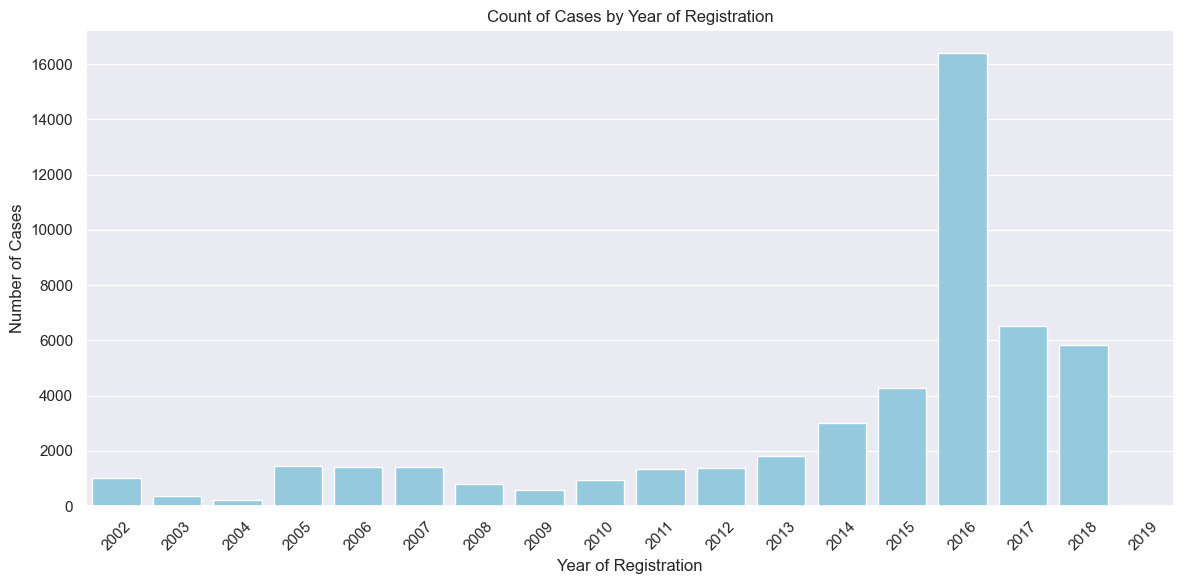

In [60]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='yearOfRegistration', color='skyblue') 
plt.title("Count of Cases by Year of Registration")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*** from this we can get that 2016 was the golden year of human trafficking (maybe some event triggered it? Some social event? crisis? migrations?).It could be also a backlog of cases being officially registered that year Also the recent years are more prominent, but 2019 is too low after all that peak maybe they didnt collect the whole year data. 

In [61]:
# Exploitation features to visualize
exploitation_features = [
    'isForcedLabour', 'isSexualExploit', 'isOtherExploit', 'isSexAndLabour', 
    'isForcedMarriage', 'isForcedMilitary', 'isOrganRemoval', 'isSlaveryAndPractices'
]

# Melt the dataframe to long format
df_melted = df[['yearOfRegistration'] + exploitation_features].melt(id_vars='yearOfRegistration', 
                                                                     var_name='ExploitType', 
                                                                     value_name='Presence')

# Filter rows where Presence is 1 (indicating the presence of the exploit type)
df_melted = df_melted[df_melted['Presence'] == 1]

# Aggregate counts by year and exploit type
df_aggregated = df_melted.groupby(['yearOfRegistration', 'ExploitType']).size().reset_index(name='Count')

# Create an interactive Plotly bar chart
fig = px.bar(df_aggregated, 
             x="yearOfRegistration", 
             y="Count", 
             color="ExploitType", 
             barmode="stack",
             title="Trends in Exploitation Types by Year of Registration",
             labels={"yearOfRegistration": "Year of Registration", "Count": "Number of Cases"},
             height=600)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Number of Cases",
    xaxis=dict(tickangle=45),
    barmode='stack',  # Stack bars to show the trend for each type of exploitation
)

# Show the plot
fig.show()


Early years: Sexual Exploitation > Forced Labour
Mid-years: Growth in Forced Labour
2016: Huge rise in Other Exploitation (plus new types appear)
After 2016: Sexual Exploitation dominates again, but dataset becomes more diverse in types.

All of this is affected by the lack of good data collection mentioned previosuly

In [62]:

# List of recruiter columns
recruiter_cols = [
    'recruiterRelationIntimatePartner', 'recruiterRelationFriend', 
    'recruiterRelationFamily', 'recruiterRelationOther', 'recruiterRelationUnknown'
]

# Group by yearOfRegistration and calculate the mean for each recruiter type
recruiter_trends = df.groupby('yearOfRegistration')[recruiter_cols].mean().reset_index()

# Create an interactive line plot using Plotly
fig = px.line(recruiter_trends, 
              x='yearOfRegistration', 
              y=recruiter_cols, 
              title="Trends in Recruiter Relationship Over Time",
              labels={"yearOfRegistration": "Year of Registration", "value": "Proportion of Cases"},
              line_shape='linear',  # Linear line connection
              markers=True,         # Show markers for each point
              height=600)

# Update layout for better aesthetics and readability
fig.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Proportion of Cases",
    xaxis=dict(tickangle=45),
    legend_title="Recruiter Relationship",
    legend=dict(title="Recruiter Relationship", x=1, y=1)
)

# Show the plot
fig.show()


** In most of the cases we don't know their relationship with the recluiter, prob victims often don't know or don't report who recruited them. This aligns with the other known relationships, since when unknown no relationship and the opposite happens. It starts to know from 2011 this could be bc in those years data collection was poor. Most of the type of relationships are not mentioned in the features that we have in the dataset. from 2011 to 2016 friend relation and family relation are prominent while from 2014 the intimate partner relation increases having its peak in 2018.

- Trafficking is often conducted by trusted people like relatives or partners, not just strangers.
- Trust-based relationships (family, partners, friends) are increasingly used as a method to exploit and traffic individuals.

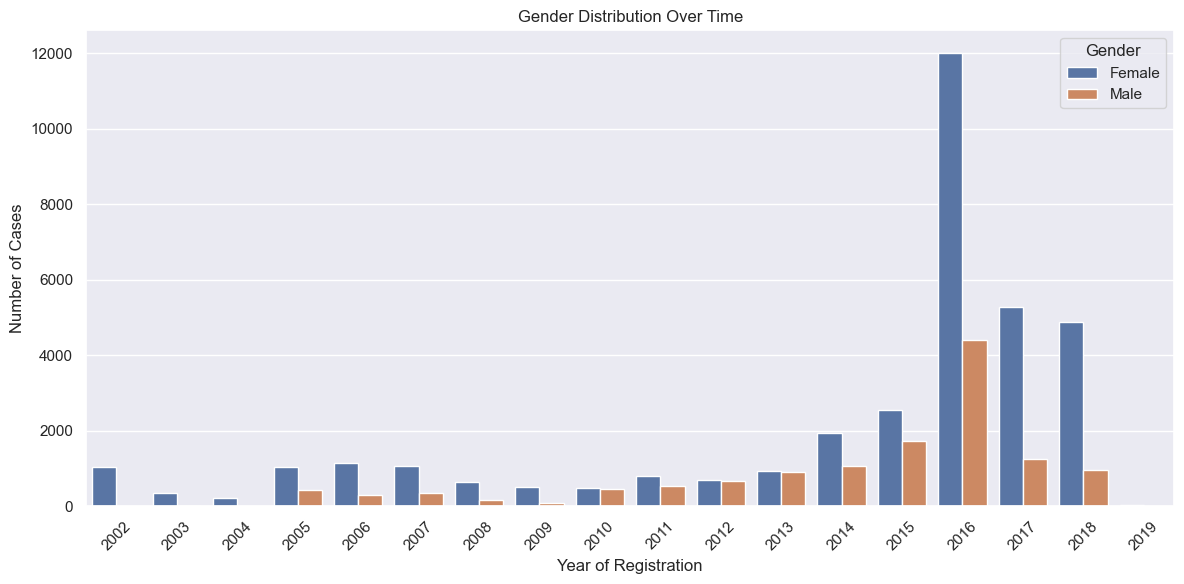

In [63]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='yearOfRegistration', hue='gender')
plt.title("Gender Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

Females are consistently the majority.
Male victim reporting increases from 2010 onward.
2016 shows a historic peak for both genders, but females still dominate (huge difference)

The spike in human trafficking cases, especially after 2010, was likely caused by better reporting, expanded legal definitions to include forced labour and other exploitations, and major global migration crises. These changes also led to more visibility of male victims, although females remained the majority

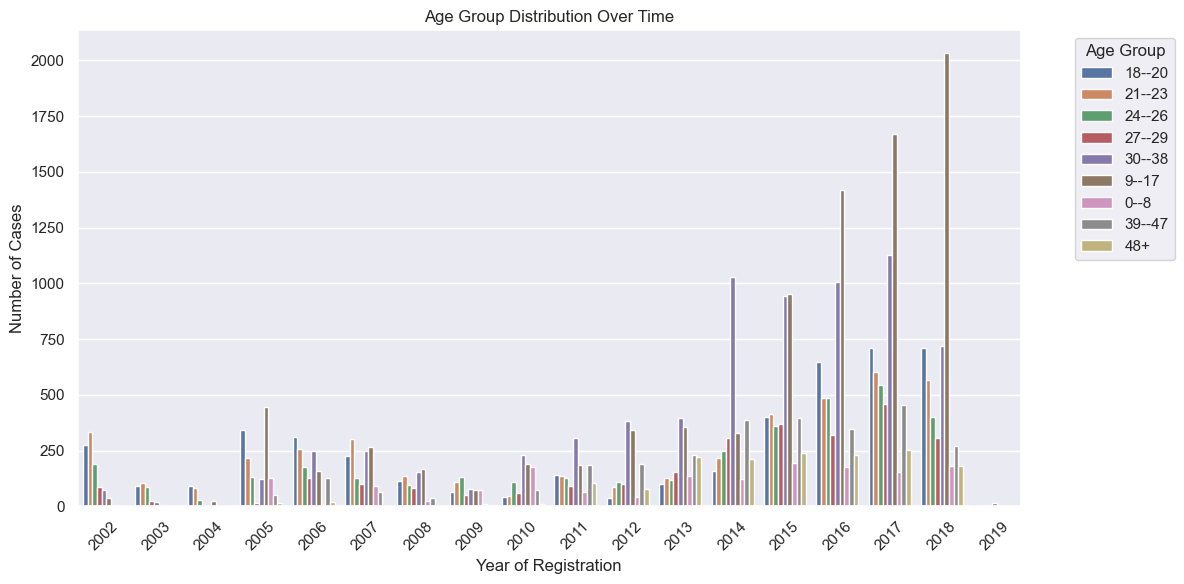

In [64]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['ageBroad']), x='yearOfRegistration', hue='ageBroad')
plt.title("Age Group Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


victims aged 9–17 increasingly became the largest group in human trafficking cases, especially after 2014, suggesting a worrying rise in child exploitation. Adult groups (18–38) also grew, but at a slower pace compared to minors

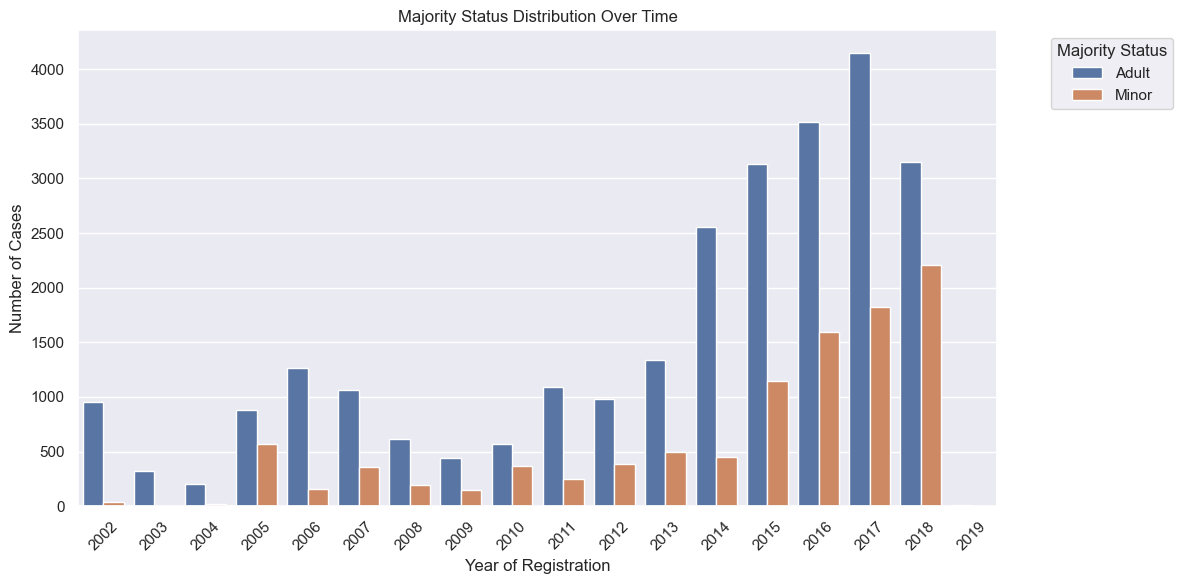

In [65]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['majorityStatus']), x='yearOfRegistration', hue='majorityStatus')
plt.title("Majority Status Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Majority Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

even though it contradicts previous comments, it is reasonable that adults cases are highers since the range of age is bigger than minors.

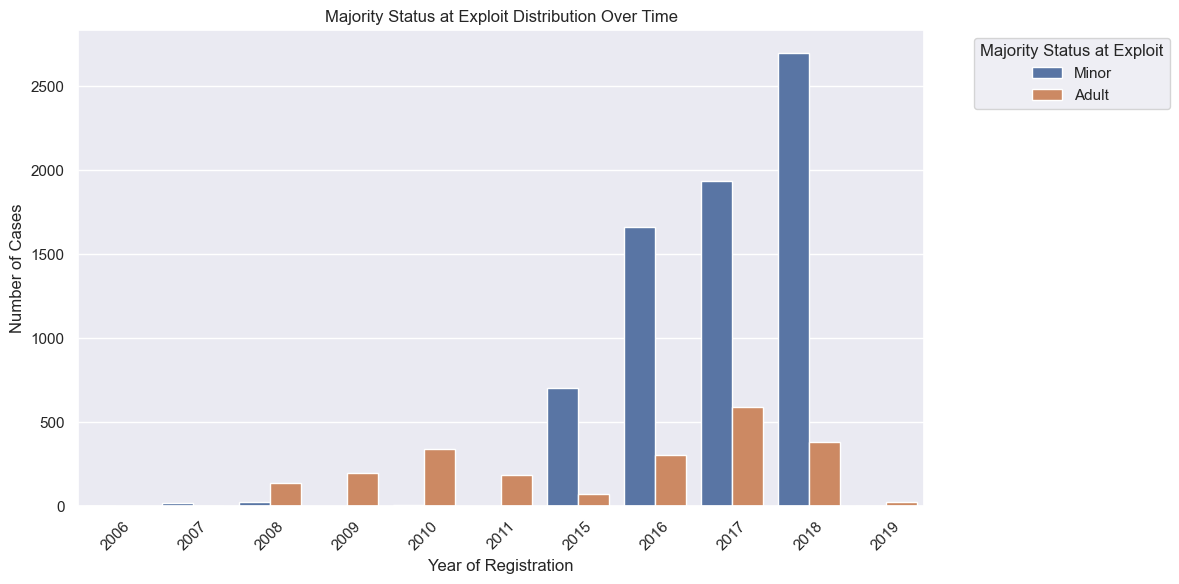

In [66]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['majorityStatusAtExploit']), x='yearOfRegistration', hue='majorityStatusAtExploit')
plt.title("Majority Status at Exploit Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Majority Status at Exploit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

** this is weird. why are more minors at the time of exploitation if when trafficked there were more adults? some people were trafficked when they were adults, but others were trafficked when they were kids and even if fewer kids were trafficked at first, they stayed trapped for longer and got exploited more.
Also, after a while, traffickers started focusing more on minors because they were easier to control and there was more demand

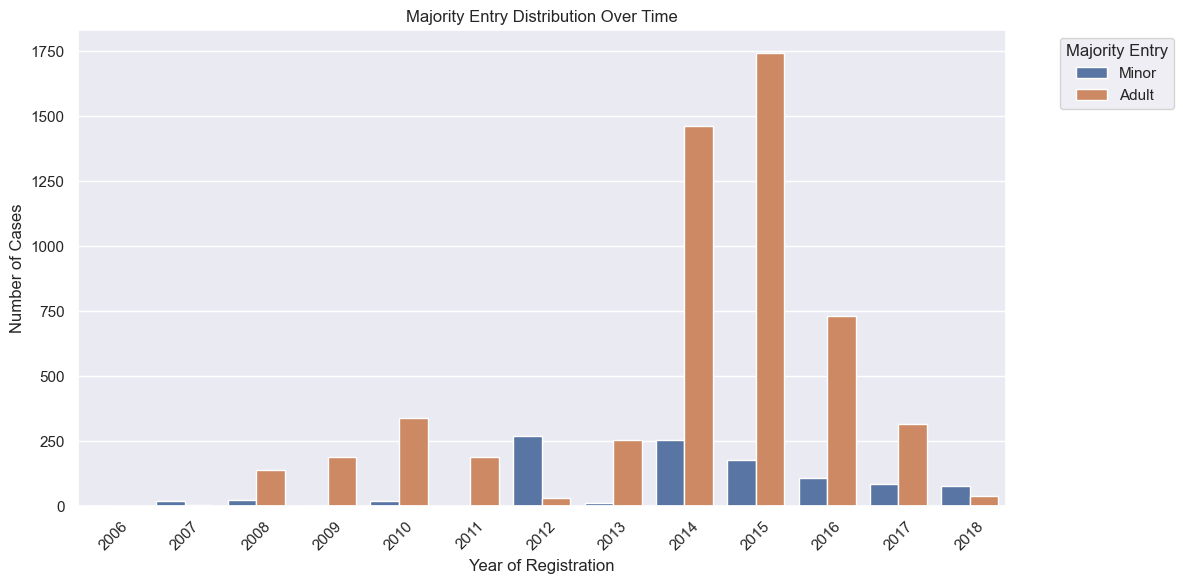

In [67]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['majorityEntry']), x='yearOfRegistration', hue='majorityEntry')
plt.title("Majority Entry Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Majority Entry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

fewer cases than it should. why at the entry there so little but for the normal distributions theres way. however the distirbution seems pretty similar despite the lack of info.

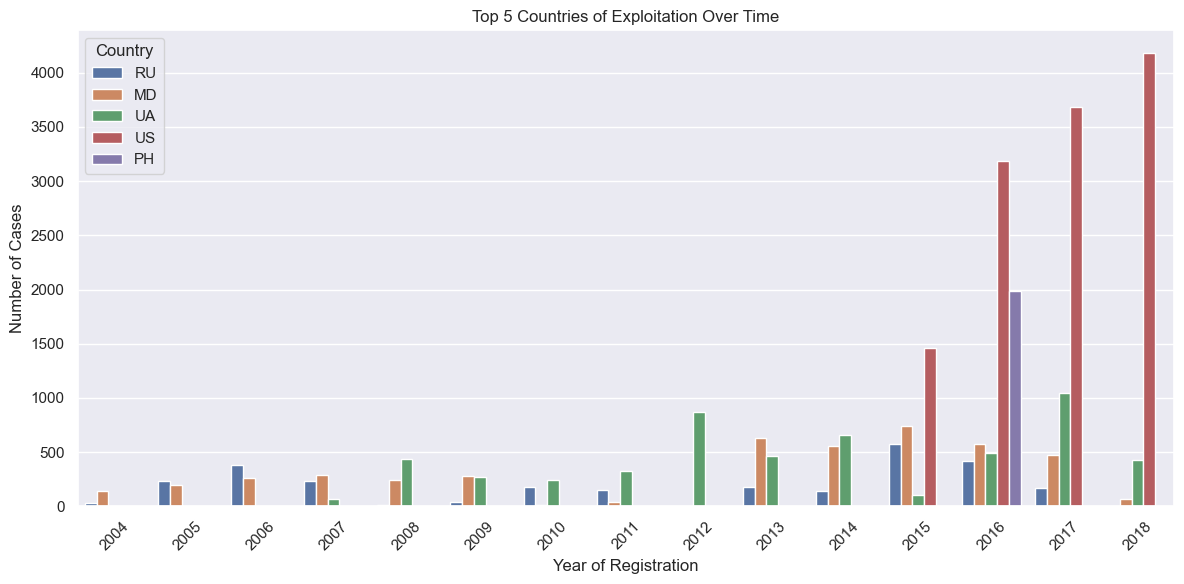

In [68]:
top_countries = df['CountryOfExploitation'].value_counts().head(5).index.tolist()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['CountryOfExploitation'].isin(top_countries)], 
              x='yearOfRegistration', hue='CountryOfExploitation')
plt.title("Top 5 Countries of Exploitation Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Country")
plt.tight_layout()
plt.show()


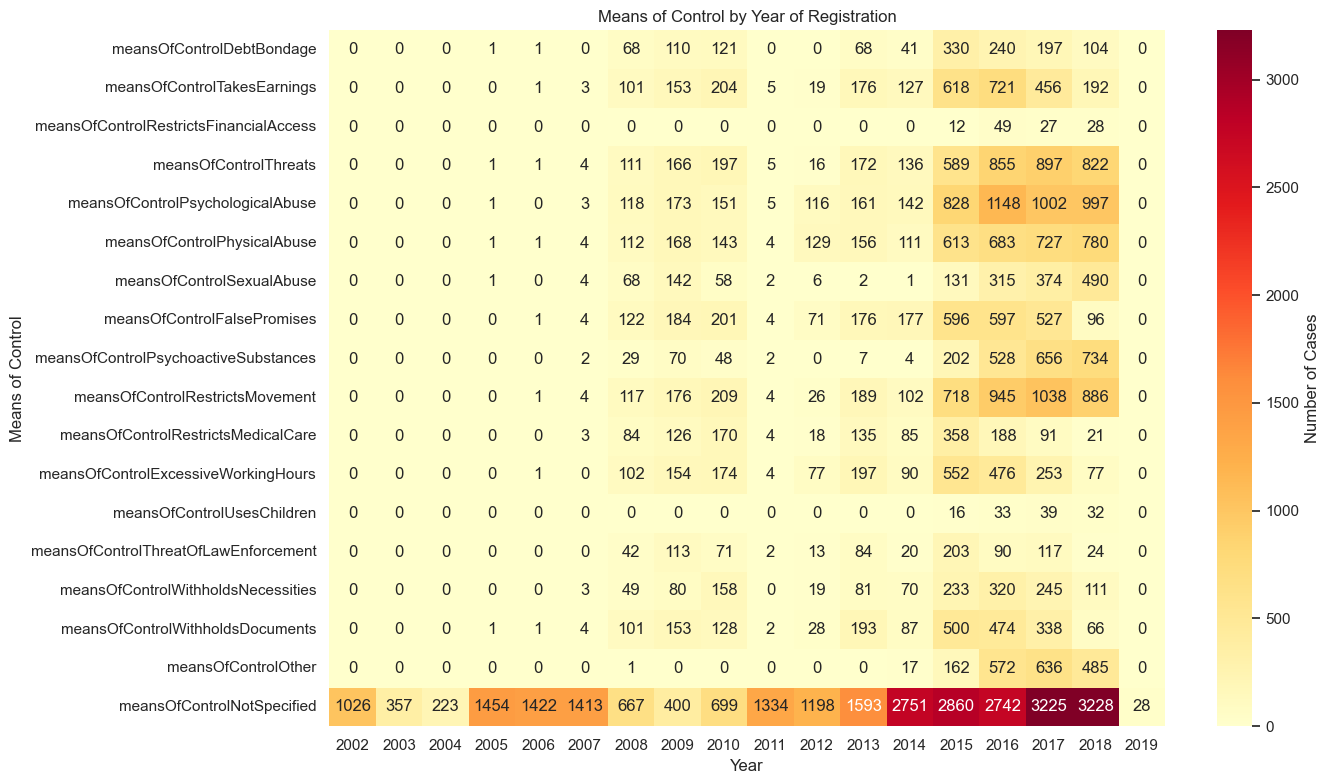

In [69]:
means_of_control_cols = [
    'meansOfControlDebtBondage',
    'meansOfControlTakesEarnings',
    'meansOfControlRestrictsFinancialAccess',
    'meansOfControlThreats',
    'meansOfControlPsychologicalAbuse',
    'meansOfControlPhysicalAbuse',
    'meansOfControlSexualAbuse',
    'meansOfControlFalsePromises',
    'meansOfControlPsychoactiveSubstances',
    'meansOfControlRestrictsMovement',
    'meansOfControlRestrictsMedicalCare',
    'meansOfControlExcessiveWorkingHours',
    'meansOfControlUsesChildren',
    'meansOfControlThreatOfLawEnforcement',
    'meansOfControlWithholdsNecessities',
    'meansOfControlWithholdsDocuments',
    'meansOfControlOther',
    'meansOfControlNotSpecified'
]

# Aggregate
yearly = df.groupby('yearOfRegistration')[means_of_control_cols].sum()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(yearly.T, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Number of Cases'})
plt.title('Means of Control by Year of Registration')
plt.xlabel('Year')
plt.ylabel('Means of Control')
plt.tight_layout()
plt.show()






After 2013, there was a sharp rise in recorded human trafficking cases, especially for Psychological Abuse, Threats, Restricts Movement, and Excessive Working Hours, which became the most prominent means of control; this surge likely reflects improved reporting practices, legal changes, or greater awareness. Earlier years mostly recorded "Not Specified" means of control, and the sudden drop in 2019 likely indicates incomplete data collection mentioned previously.

##### more detailed code for means of control for each year of registration

In [70]:
# Aggregate
yearly = df.groupby('yearOfRegistration')[means_of_control_cols].sum().reset_index()

# Create traces for each control
fig = go.Figure()

for control in means_of_control_cols:
    fig.add_trace(
        go.Bar(x=yearly['yearOfRegistration'], y=yearly[control], name=control, visible=False)
    )

# Make first one visible
fig.data[0].visible = True

# Dropdown buttons
buttons = []
for i, control in enumerate(means_of_control_cols):
    visible = [False] * len(means_of_control_cols)
    visible[i] = True
    buttons.append(
        dict(label=control,
             method='update',
             args=[{'visible': visible},
                   {'title': f'Means of Control: {control}'}])
    )

# Layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.05)],
    title='Means of Control: ' + means_of_control_cols[0],
    xaxis_title='Year of Registration',
    yaxis_title='Number of Cases'
)

fig.show()



** maybe for amjority status i have to check it's not redundant with the age range, cuz maybe we have to drop it since its repeptitive information.

#### Datasource

In [71]:
df[['Datasource']].info()
df['Datasource'].value_counts()
df[['Datasource']].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Datasource  48801 non-null  object
dtypes: object(1)
memory usage: 381.4+ KB


Datasource    0
dtype: int64

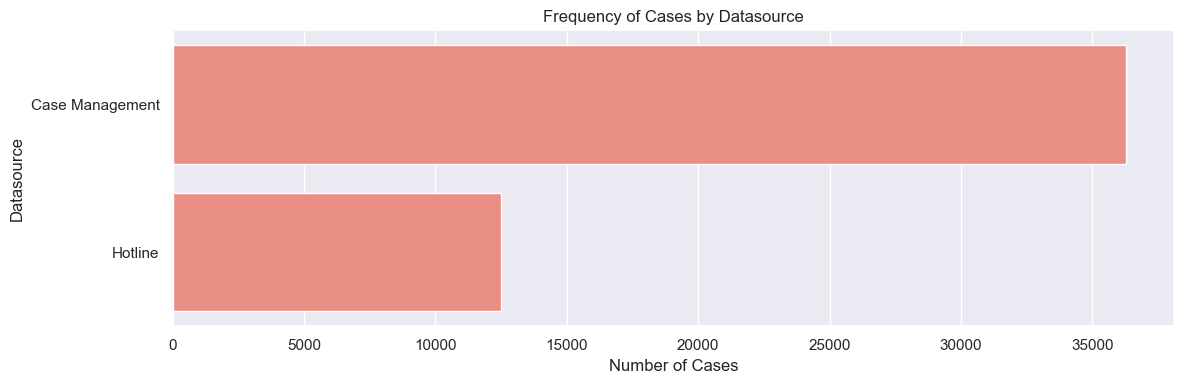

In [72]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, y='Datasource', order=df['Datasource'].value_counts().index, color='salmon')
plt.title("Frequency of Cases by Datasource")
plt.xlabel("Number of Cases")
plt.ylabel("Datasource")
plt.tight_layout()
plt.show()

Case Management System (CMS)
These are formal systems used by NGOs, government agencies, shelters, etc., to manage cases of victims they are helping.
How CMS can affect the data:
- More Detailed Data: Trained professionals collect structured information, often after spending time with the victim.
- Cross-checked: Case workers can verify details (like age, citizenship) by asking follow-up questions.

- Bias Toward Detected Victims: CMS usually records only people who have already been rescued or identified. Not hidden cases.
- Longer Time Gap: Cases might get registered months or even years after trafficking happened → affects things like registrationYear.
- Formal definitions: They follow strict definitions of trafficking, so some gray area cases may be excluded.

Example of affected features: registrationYear, majorityEntry, ageBroad, meansOfControl

Hotline Reports
Hotlines are anonymous or semi-anonymous tip lines where victims or witnesses call in.
How Hotline data can affect the data:
- Real-time Reporting: You get very fresh data — closer to when the trafficking is happening.
- More Diverse Cases: Includes hidden populations who would not go to authorities.

- Incomplete Data: People may only give partial info ("I saw a girl being forced to work") → missing values.
- More Unverified: It's hard to confirm what really happened from just a call.
- Misclassification Risk: A caller might mistake a bad labor practice for trafficking, or vice versa.

Example of affected features:
countryOfExploitation, typeOfExploitation, recruiterRelation, meansOfControl, ageBroad

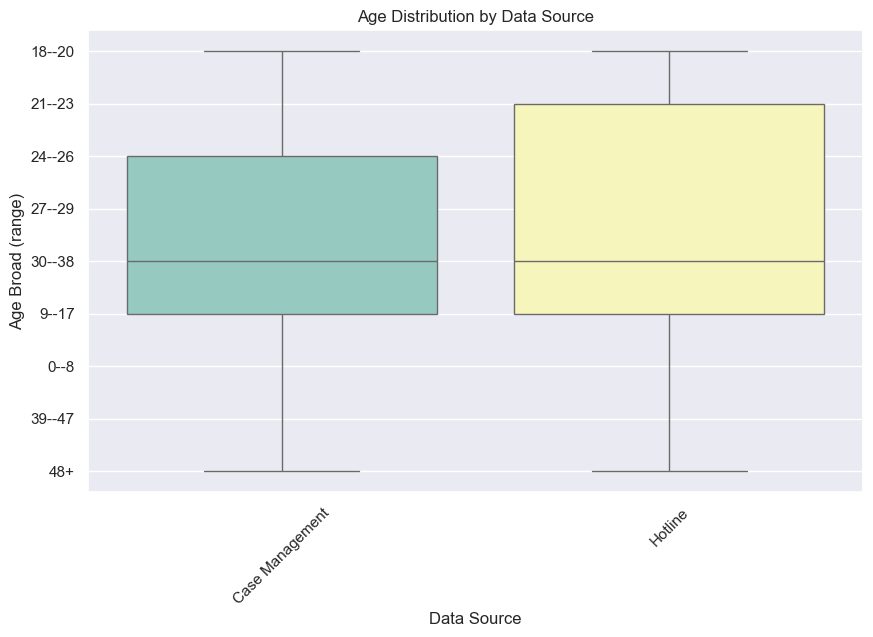

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Datasource', y='ageBroad', hue='Datasource', palette='Set3', legend=False)
plt.title('Age Distribution by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Age Broad (range)')
plt.xticks(rotation=45)
plt.show()


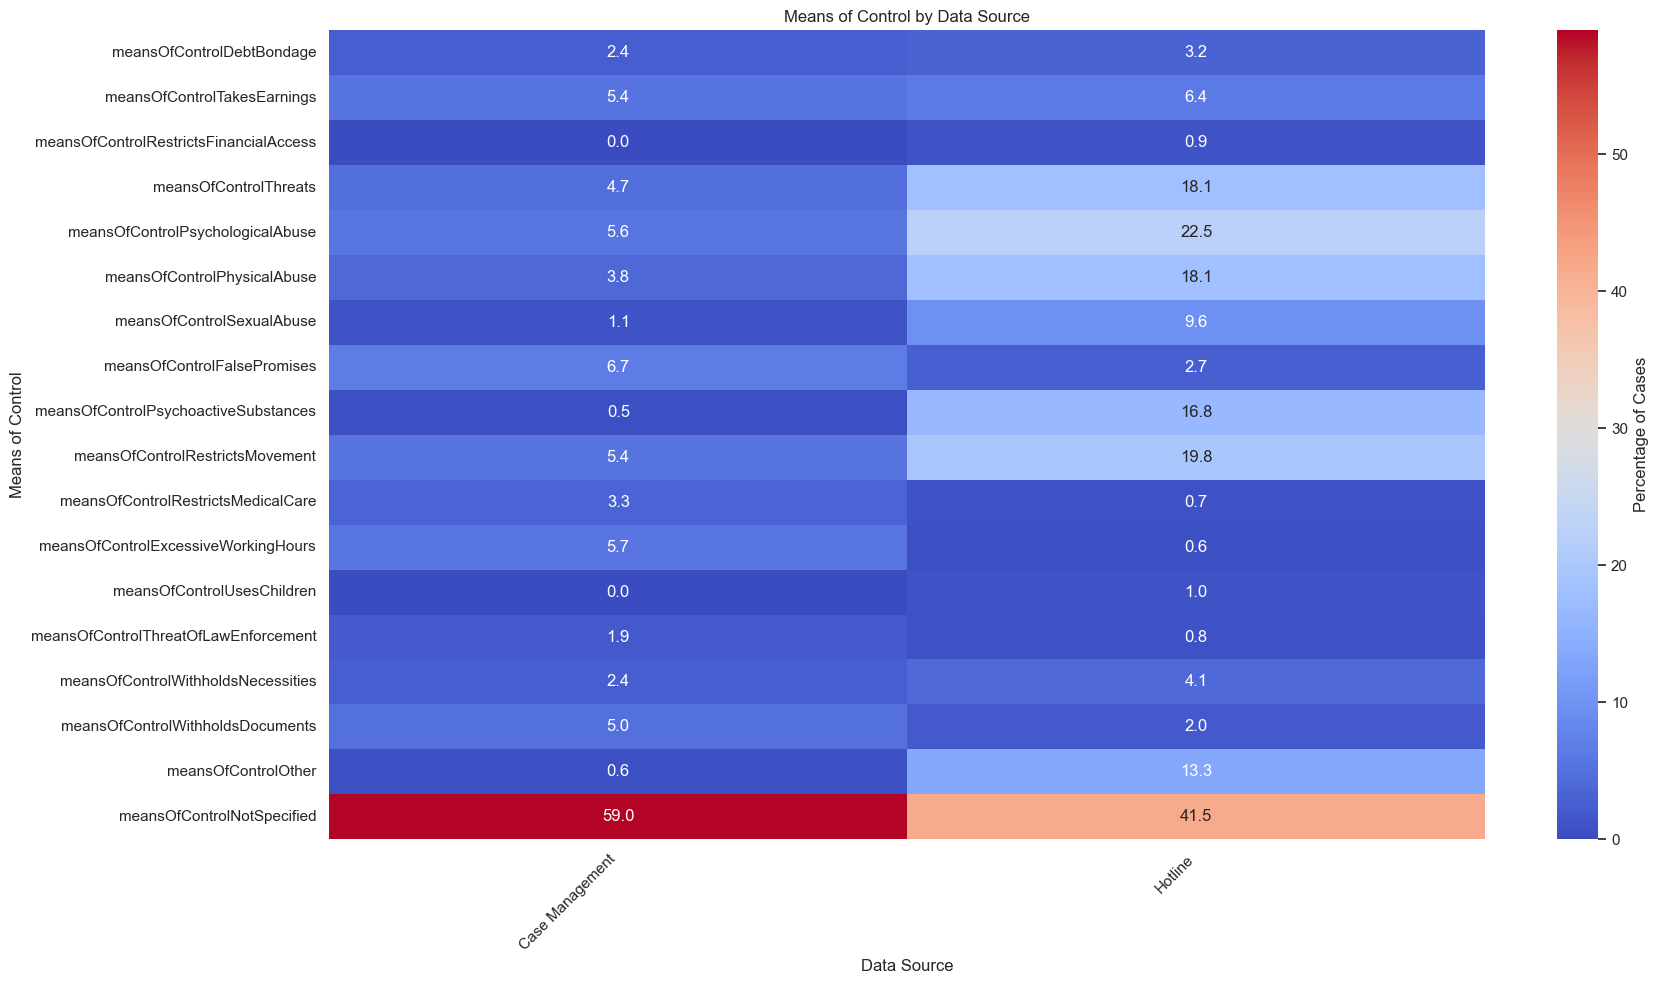

In [74]:
# Count how many cases exist per datasource
source_counts = df['Datasource'].value_counts()

# Now calculate the correct percentage for each means of control
heatmap_data = {}

for control in means_of_control_cols:
    counts = df.groupby('Datasource')[control].sum()  # Sum where control was 1
    percentages = counts / source_counts * 100         # Calculate % over total cases in that source
    heatmap_data[control] = percentages

# Create a DataFrame
heatmap_df = pd.DataFrame(heatmap_data).T  # transpose to get controls as rows

# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Percentage of Cases'})
plt.title('Means of Control by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Means of Control')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 2.1.1 Victim Demographics

### 2.1.2 Type of Exploitation

### 2.1.3 Type of Labour

### 2.1.4 Type of Sexual Exploitation

### 2.1.5 Types of Recuiter Relationship and Country of Exploitation

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# Optional: Set plotting style
sns.set(style="whitegrid")


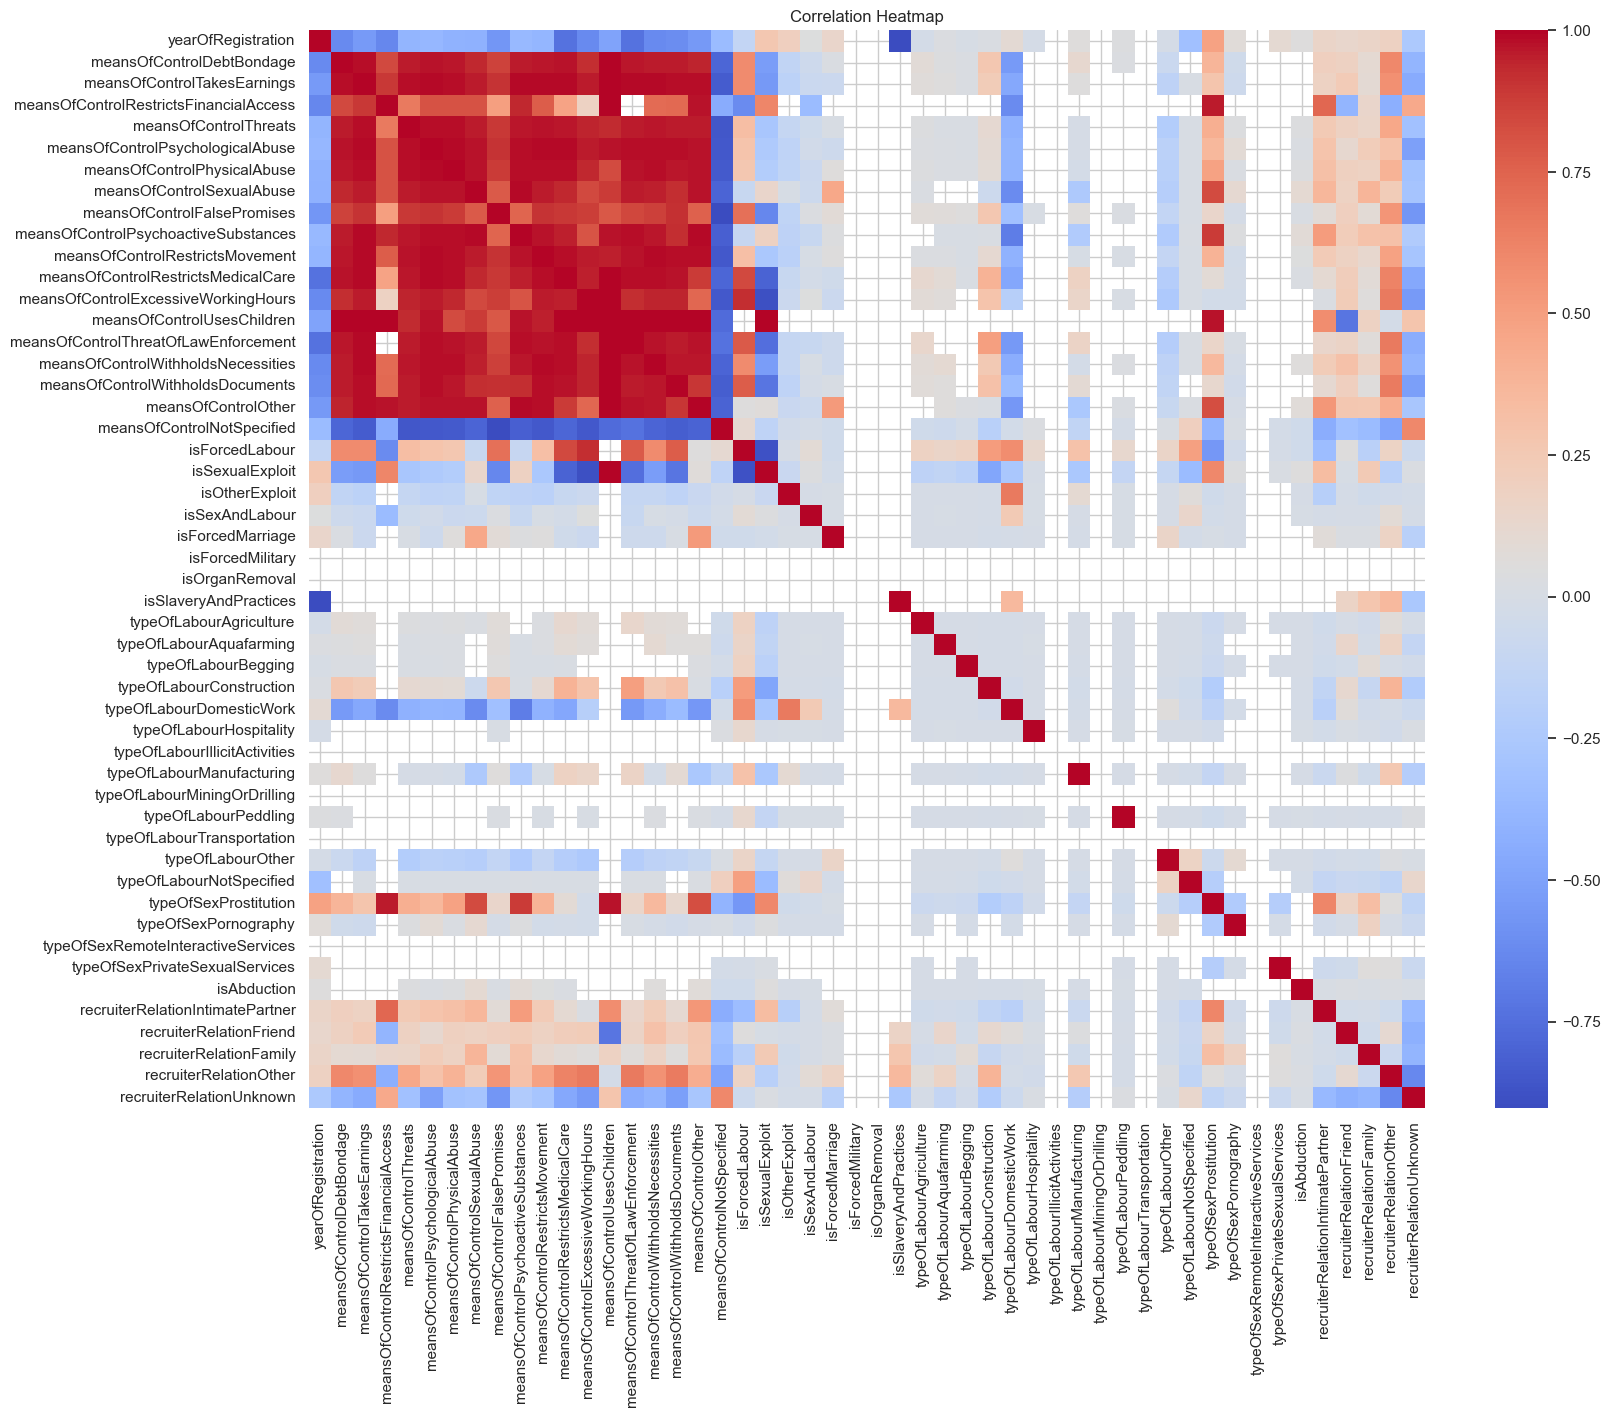

In [76]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


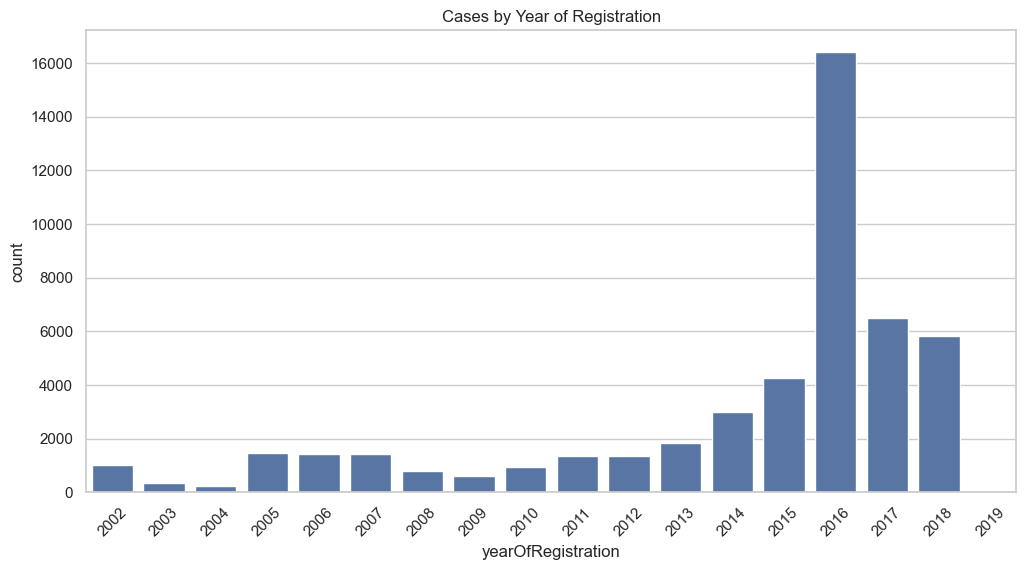

In [77]:
plt.figure(figsize=(12, 6))
sns.countplot(x='yearOfRegistration', data=df, order=sorted(df['yearOfRegistration'].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Cases by Year of Registration")
plt.show()


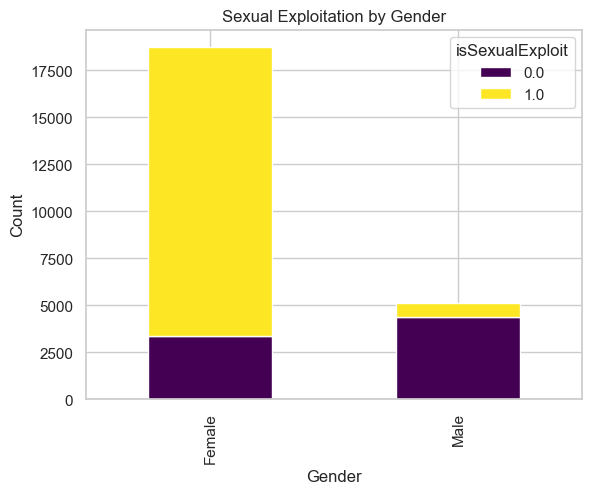

In [78]:
cross_tab = pd.crosstab(df['gender'], df['isSexualExploit'])
cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sexual Exploitation by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(title='isSexualExploit')
plt.show()


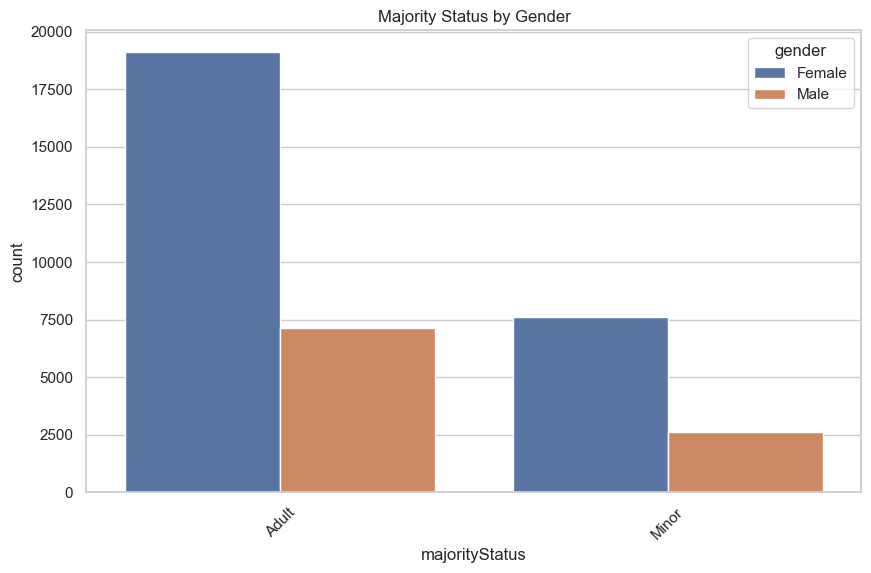

In [79]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='majorityStatus', hue='gender')
plt.title("Majority Status by Gender")
plt.xticks(rotation=45)
plt.show()


In [80]:
%pip install pycountry


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [81]:
import pycountry
import plotly.express as px

# Create a mapping from ISO alpha-2 codes to full country names
def code_to_country(code):
    try:
        if pd.isna(code) or code == '00':
            return 'Unknown'
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Apply the mapping
df['citizenship_country'] = df['citizenship'].apply(code_to_country)

# Count occurrences
country_counts = df['citizenship_country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot the choropleth map
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Cases by Citizenship Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [82]:
country_counts = df['CountryOfExploitation'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Exploitation Cases by Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [83]:
subset = df[['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']].dropna().copy()
subset = subset[subset['typeOfExploitConcatenated'] != '']

subset = subset.groupby(['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']).size().reset_index(name='count')

# Create node list
all_nodes = pd.concat([
    subset['gender'],
    subset['typeOfExploitConcatenated'],
    subset['CountryOfExploitation']
]).unique().tolist()

# Map node labels to index
label_to_idx = {label: idx for idx, label in enumerate(all_nodes)}

# Create links
source = subset['gender'].map(label_to_idx)
target = subset['typeOfExploitConcatenated'].map(label_to_idx)
middle_target = subset['CountryOfExploitation'].map(label_to_idx)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=subset['count']
    )
)])

fig.update_layout(title_text="Sankey Diagram: Gender → Type of Exploitation", font_size=10)
fig.show()


## Section 3. Handling Missing Values

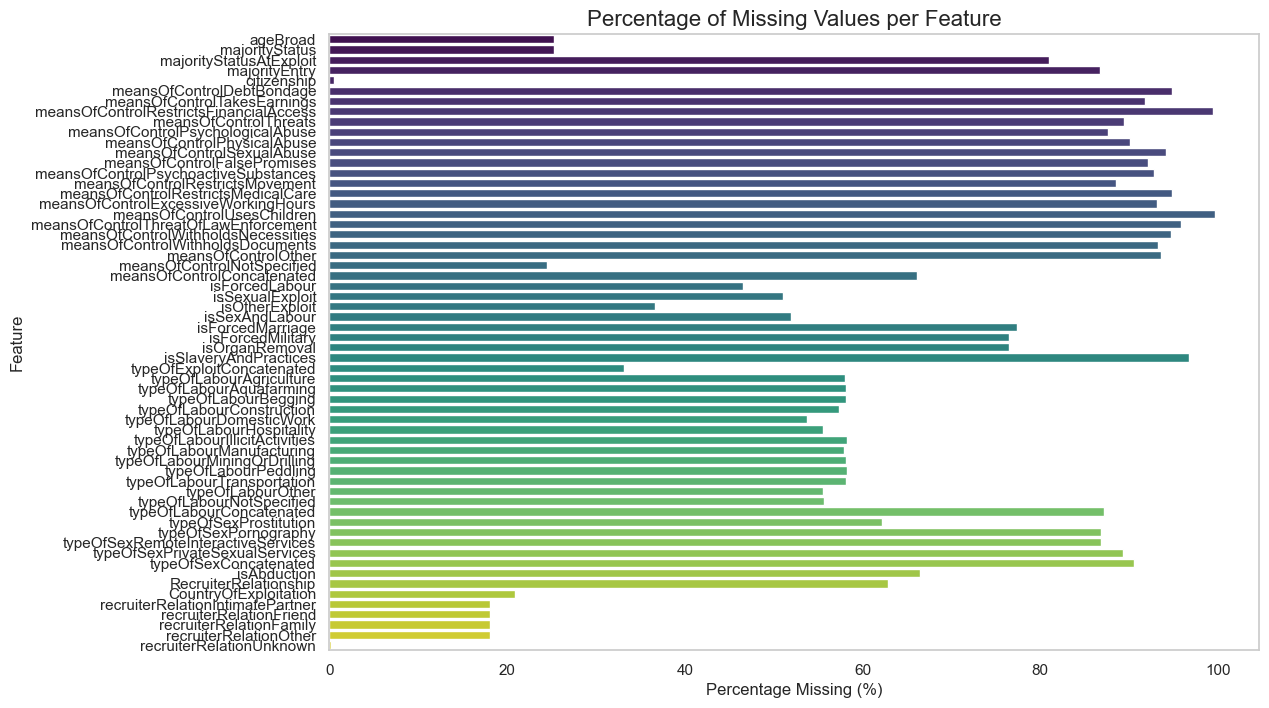

In [84]:
# 1. Calculate missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Keep only columns with missing values
missing_percentage = (missing_values / len(df)) * 100

# 2. Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")
plt.title('Percentage of Missing Values per Feature', fontsize=16)
plt.xlabel('Percentage Missing (%)')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()


#Apporach to be  determined

#Lots of features have a 1 or a 0 or -99 and -99 can be swapped out with 0 if we want


In [1]:
X = df.copy()

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values for categorical columns
X[categorical_cols] = X[categorical_cols].fillna('Unknown')  # 'Unknown' for categorical variables

# Fill missing values for numerical columns
X[numerical_cols] = X[numerical_cols].fillna(0)  # 0 for numerical variables (or you could use median/mean)

NameError: name 'df' is not defined

## Section 4. Handling Missing Values, Feature Engineering, and Scaling

In [90]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Define evaluation function early (before it's used)
def evaluate_multi_target(y_true, y_pred, model_name):
    """Evaluate multi-target model with appropriate metrics"""
    # Existing metrics
    hl = hamming_loss(y_true, y_pred)
    subset_accuracy = np.all(y_true.values == y_pred, axis=1).mean()
    macro_f1 = f1_score(y_true.values.ravel(), y_pred.ravel(), average='macro', zero_division=0)


    # Add Cohen's Kappa (professor's recommendation for imbalanced data)
    kappa = cohen_kappa_score(y_true.values.ravel(), y_pred.ravel())

    # Per-label metrics
    per_label_f1 = {}
    per_label_recall = {}  # Professor recommended per-class recall
    for i, col in enumerate(y_true.columns):
        f1 = f1_score(y_true.iloc[:, i], y_pred[:, i], zero_division=0)
        recall = classification_report(y_true.iloc[:, i], y_pred[:, i], output_dict=True)['1']['recall']
        per_label_f1[col] = f1
        per_label_recall[col] = recall

    # Print results
    print(f"\n{model_name} Evaluation:")
    print(f"Hamming Loss: {hl:.4f}")
    print(f"Subset Accuracy: {subset_accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    print("\nPer-label F1 Scores:")
    for label, score in per_label_f1.items():
        print(f"{label}: {score:.4f}")

    print("\nPer-label Recall (Sensitivity):")
    for label, score in per_label_recall.items():
        print(f"{label}: {score:.4f}")

    return {
        'model': model_name,
        'hamming_loss': hl,
        'subset_accuracy': subset_accuracy,
        'macro_f1': macro_f1,
        'kappa': kappa,
        'per_label_f1': per_label_f1,
        'per_label_recall': per_label_recall
    }

# ----------------------
# Data Preprocessing
# ----------------------

# Replace -99 with NaN for proper handling
df.replace(-99, np.nan, inplace=True)

# Create a copy for multi-target classification
df_multi = df.copy()

# Drop columns with excessive missing values or those not useful for prediction
columns_to_drop = [
    'yearOfRegistration',  # Administrative timestamp, not predictive
    'Datasource',  # Source of data collection, not relevant for prediction
    'meansOfControlConcatenated',  # Redundant with individual meansOfControl columns
    'typeOfExploitConcatenated',   # Redundant with individual exploitation type columns
    'typeOfLabourConcatenated',    # Redundant with individual labour type columns
    'typeOfSexConcatenated',       # Redundant with individual sex exploitation type columns
    'RecruiterRelationship',       # High missing values and covered by detailed recruiter columns
]

df_multi = df_multi.drop(columns_to_drop, axis=1, errors='ignore')

# Define target variables (keep binary exploitation flags for multi-target)
target_columns = [
    'isForcedLabour',
    'isSexualExploit',
    'isOtherExploit',
    'isSexAndLabour',
    'isForcedMarriage'
]

# ----------------------
# REMOVING LEAKY FEATURES
# ----------------------

# 1. Remove post-exploitation information
post_exploitation_cols = ['CountryOfExploitation']
df_multi = df_multi.drop(post_exploitation_cols, axis=1, errors='ignore')

# 2. Remove all exploitation type indicators
# These directly relate to what we're trying to predict
exploitation_type_cols = [col for col in df_multi.columns if col.startswith('typeOfLabour') or
                         col.startswith('typeOfSex') or
                         col in ['isForcedMilitary', 'isOrganRemoval', 'isSlaveryAndPractices']]
df_multi = df_multi.drop(exploitation_type_cols, axis=1, errors='ignore')

# 3. Consider whether means of control features would be known before exploitation
# This is a critical decision - for a predictive model, they should be removed if only known after exploitation
means_of_control_cols = [col for col in df_multi.columns if col.startswith('meansOfControl')]
print(f"Removing {len(means_of_control_cols)} 'means of control' features, which would typically only be known post-exploitation.")
df_multi = df_multi.drop(means_of_control_cols, axis=1, errors='ignore')

# 4. Check for any other leaky features
# For a truly predictive model, we might only have demographic and origin information
other_leaky_cols = ['isAbduction']  # Only known after the fact
df_multi = df_multi.drop(other_leaky_cols, axis=1, errors='ignore')

# Report the remaining features
print(f"Removed leaky features. Remaining feature count: {df_multi.shape[1] - len(target_columns)}")
print("Remaining features (excluding targets):")
non_target_cols = [col for col in df_multi.columns if col not in target_columns]
print(", ".join(non_target_cols))

# ----------------------
# Continuing with proper feature preparation
# ----------------------

# Drop target variables from features
X_multi = df_multi.drop(target_columns, axis=1, errors='ignore')
y_multi = df_multi[target_columns].fillna(0).astype(int)  # Ensure targets are binary and without NaNs

# Handle missing values in features
# For numerical columns, fill with median
numerical_cols = X_multi.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_multi.select_dtypes(include=['object']).columns

# Numerical imputation
numerical_imputer = SimpleImputer(strategy='median')
X_multi[numerical_cols] = numerical_imputer.fit_transform(X_multi[numerical_cols])

# Categorical imputation and encoding
for col in categorical_cols:
    # Fill missing with most frequent
    X_multi[col] = X_multi[col].fillna(X_multi[col].mode()[0])

    # Encode categorical variables
    le = LabelEncoder()
    X_multi[col] = le.fit_transform(X_multi[col])

# ----------------------
# Feature Engineering
# ----------------------

# 1. Group sparse binary features (for recruiter information)
recruiter_cols = [col for col in X_multi.columns if col.startswith('recruiterRelation')]
if len(recruiter_cols) > 0:
    # Create count of recruiter relationship types
    X_multi['num_recruiter_relations'] = X_multi[recruiter_cols].sum(axis=1)

    # Create binned version (0, 1, many)
    X_multi['recruiter_relation_bin'] = X_multi['num_recruiter_relations'].apply(
        lambda x: 0 if x == 0 else (1 if x == 1 else 2)
    )

    # Create high-risk recruiter indicator (intimate partner or unknown)
    if 'recruiterRelationIntimatePartner' in X_multi.columns and 'recruiterRelationUnknown' in X_multi.columns:
        X_multi['high_risk_recruiter'] = ((X_multi['recruiterRelationIntimatePartner'] == 1) |
                                         (X_multi['recruiterRelationUnknown'] == 1)).astype(int)

    print(f"Created aggregated features from {len(recruiter_cols)} recruiter relationship columns")

# 2. Age Vulnerability (based solely on demographic info)
if 'ageBroad' in X_multi.columns:
    # Create age vulnerability score
    age_vulnerability = {
        '0--8': 5,    # Highest vulnerability for very young children
        '9--17': 4,   # High vulnerability for older children
        '18--20': 3,  # Moderate-high vulnerability for young adults
        '21--23': 2,  # Moderate vulnerability
        '24--26': 2,  # Moderate vulnerability
        '27--29': 1,  # Low-moderate vulnerability
        '30--38': 1,  # Low-moderate vulnerability
        '39--47': 1,  # Low-moderate vulnerability
        '48+': 1      # Low-moderate vulnerability
    }

    # Map string categories if we have the raw age categories
    if X_multi['ageBroad'].dtype == 'object':
        X_multi['age_vulnerability'] = X_multi['ageBroad'].map(lambda x: age_vulnerability.get(x, 1))
    else:
        # Try to map based on values if already encoded
        print("Age categories already encoded - creating approximate vulnerability score")
        max_age_val = X_multi['ageBroad'].max()

        # Create a normalized score where lower values (younger ages) get higher vulnerability
        if max_age_val > 0:  # Ensure we don't divide by zero
            X_multi['age_vulnerability'] = 5 - 4 * (X_multi['ageBroad'] / max_age_val)
            X_multi['age_vulnerability'] = X_multi['age_vulnerability'].clip(1, 5)

# 3. Gender vulnerability (based solely on demographic info)
if 'gender' in X_multi.columns:
    # If gender is already encoded
    if X_multi['gender'].dtype != 'object':
        # Find the most likely encoding (check which value is more prevalent)
        female_code = X_multi['gender'].value_counts().index[0]  # Assuming females are the majority
        X_multi['gender_vulnerability'] = (X_multi['gender'] == female_code).astype(int) * 2 + 1
    else:
        X_multi['gender_vulnerability'] = X_multi['gender'].map({'Female': 3, 'Male': 1}).fillna(2)

# 4. Region of origin with more meaningful encoding (professor's recommendation)
if 'citizenship' in X_multi.columns:
    # Function to create region mapping
    def get_region(country_code):
        """Map country codes to broader geographic regions"""
        # Regional mappings (adjust based on your data and domain knowledge)
        eastern_europe = ['UA', 'RU', 'MD', 'BY', 'RO', 'BG', 'PL', 'HU', 'SK', 'CZ']
        western_europe = ['DE', 'FR', 'IT', 'ES', 'PT', 'UK', 'IE', 'BE', 'NL', 'AT', 'CH']
        northern_europe = ['SE', 'NO', 'FI', 'DK', 'IS', 'EE', 'LV', 'LT']
        southern_europe = ['GR', 'HR', 'RS', 'ME', 'MK', 'AL', 'BA', 'SI', 'CY', 'MT']
        north_america = ['US', 'CA']
        central_america = ['MX', 'GT', 'BZ', 'SV', 'HN', 'NI', 'CR', 'PA']
        south_america = ['CO', 'VE', 'GY', 'SR', 'BR', 'EC', 'PE', 'BO', 'PY', 'CL', 'AR', 'UY']
        caribbean = ['CU', 'HT', 'DO', 'JM', 'BS', 'BB']
        east_asia = ['CN', 'JP', 'KR', 'KP', 'TW', 'MN', 'HK']
        southeast_asia = ['VN', 'LA', 'KH', 'TH', 'MM', 'MY', 'SG', 'ID', 'PH', 'BN', 'TL']
        south_asia = ['IN', 'PK', 'BD', 'NP', 'BT', 'LK', 'MV', 'AF']
        central_asia = ['KZ', 'UZ', 'TM', 'KG', 'TJ']
        middle_east = ['TR', 'CY', 'SY', 'LB', 'IQ', 'IR', 'IL', 'JO', 'SA', 'YE', 'OM', 'AE', 'QA', 'BH', 'KW']
        northern_africa = ['EG', 'LY', 'TN', 'DZ', 'MA', 'SD', 'SS']
        western_africa = ['MR', 'ML', 'NE', 'NG', 'BF', 'SN', 'GM', 'GW', 'GN', 'SL', 'LR', 'CI', 'GH', 'TG', 'BJ']
        central_africa = ['TD', 'CF', 'CM', 'GQ', 'GA', 'CG', 'CD', 'AO']
        eastern_africa = ['ET', 'ER', 'DJ', 'SO', 'KE', 'UG', 'RW', 'BI', 'TZ']
        southern_africa = ['ZM', 'ZW', 'MW', 'MZ', 'BW', 'NA', 'ZA', 'LS', 'SZ']
        oceania = ['AU', 'NZ', 'PG', 'FJ', 'SB', 'VU', 'WS', 'TO', 'NR', 'PW', 'FM', 'MH', 'TV', 'KI']

        # Group regions into broader categories
        if country_code in eastern_europe:
            return 'Eastern Europe'
        elif country_code in western_europe or country_code in northern_europe or country_code in southern_europe:
            return 'Rest of Europe'
        elif country_code in north_america:
            return 'North America'
        elif country_code in central_america or country_code in south_america or country_code in caribbean:
            return 'Latin America & Caribbean'
        elif country_code in east_asia or country_code in southeast_asia:
            return 'East & Southeast Asia'
        elif country_code in south_asia or country_code in central_asia:
            return 'South & Central Asia'
        elif country_code in middle_east:
            return 'Middle East'
        elif country_code in northern_africa or country_code in western_africa or country_code in central_africa or country_code in eastern_africa or country_code in southern_africa:
            return 'Africa'
        elif country_code in oceania:
            return 'Oceania'
        else:
            return 'Other/Unknown'

    # Human Development Index tiers by region (simplified example)
    hdi_tiers = {
        'North America': 4,           # Very High HDI
        'Rest of Europe': 4,          # Very High HDI
        'Oceania': 3,                 # High HDI
        'Eastern Europe': 3,          # High HDI
        'Latin America & Caribbean': 2, # Medium HDI
        'Middle East': 2,             # Medium HDI
        'East & Southeast Asia': 2,   # Medium HDI
        'South & Central Asia': 1,    # Low HDI
        'Africa': 1,                  # Low HDI
        'Other/Unknown': 2            # Default Medium
    }

    # Conflict risk by region (simplified example)
    conflict_risk = {
        'North America': 1,             # Low risk
        'Rest of Europe': 1,            # Low risk
        'Oceania': 1,                   # Low risk
        'Eastern Europe': 3,            # High risk (border conflicts)
        'Latin America & Caribbean': 2,  # Medium risk
        'Middle East': 3,               # High risk
        'East & Southeast Asia': 2,      # Medium risk
        'South & Central Asia': 3,       # High risk
        'Africa': 3,                     # High risk
        'Other/Unknown': 2              # Default Medium risk
    }

    # Only create origin region feature (not destination, which is leaky)
    if X_multi['citizenship'].dtype == 'object':
        # Create region from citizenship
        X_multi['origin_region'] = X_multi['citizenship'].apply(get_region)

        # Create HDI tier from region
        X_multi['origin_hdi_tier'] = X_multi['origin_region'].map(hdi_tiers)

        # Create conflict risk from region
        X_multi['origin_conflict_risk'] = X_multi['origin_region'].map(conflict_risk)

        # Encode the categorical region
        origin_encoder = LabelEncoder()
        X_multi['origin_region'] = origin_encoder.fit_transform(X_multi['origin_region'])

        print("Created and encoded meaningful region features from citizenship")
    elif 'citizenship' in X_multi.columns:
        print("Citizenship already encoded - skipping region mapping")

# 5. Create high-risk origin indicator (based on domain knowledge)
# This uses only pre-trafficking information
high_risk_regions = [
    'Eastern Europe',
    'Africa',
    'South & Central Asia',
    'East & Southeast Asia'
]

if 'origin_region' in X_multi.columns and X_multi['origin_region'].dtype == 'object':
    X_multi['high_risk_origin'] = X_multi['origin_region'].isin(high_risk_regions).astype(int)
    print("Created high risk origin indicator")

# 6. Majority status features
if 'majorityStatus' in X_multi.columns and 'majorityEntry' in X_multi.columns:
    # Create feature indicating if person was a minor at any point
    if X_multi['majorityStatus'].dtype == 'object' and X_multi['majorityEntry'].dtype == 'object':
        X_multi['ever_minor'] = ((X_multi['majorityStatus'] == 'Minor') |
                                (X_multi['majorityEntry'] == 'Minor')).astype(int)
    else:
        # Simplified approach if already encoded - adjust based on your encoding
        minor_status_code = X_multi['majorityStatus'].value_counts().index[1]  # Assuming minor is less common
        minor_entry_code = X_multi['majorityEntry'].value_counts().index[1]
        X_multi['ever_minor'] = ((X_multi['majorityStatus'] == minor_status_code) |
                                (X_multi['majorityEntry'] == minor_entry_code)).astype(int)

    print("Created feature indicating if person was ever a minor")

# 7. Create vulnerability score using non-leaky features only
vulnerability_components = []
weights = []

if 'age_vulnerability' in X_multi.columns:
    vulnerability_components.append(X_multi['age_vulnerability'])
    weights.append(3)  # Age is a strong factor

if 'gender_vulnerability' in X_multi.columns:
    vulnerability_components.append(X_multi['gender_vulnerability'])
    weights.append(2)  # Gender is a moderate factor

if 'origin_conflict_risk' in X_multi.columns:
    vulnerability_components.append(X_multi['origin_conflict_risk'])
    weights.append(2)  # Conflict risk is a moderate factor

if 'origin_hdi_tier' in X_multi.columns:
    # Invert HDI tier since lower HDI means higher vulnerability
    vulnerability_components.append(5 - X_multi['origin_hdi_tier'])
    weights.append(2)  # HDI is a moderate factor

if 'ever_minor' in X_multi.columns:
    # Scale up the minor indicator to match the 1-5 scale
    vulnerability_components.append(X_multi['ever_minor'] * 4 + 1)
    weights.append(3)  # Minor status is a strong factor

# Calculate weighted vulnerability score
if vulnerability_components:
    weighted_sum = sum(w * c for w, c in zip(weights, vulnerability_components))
    X_multi['vulnerability_score'] = weighted_sum / sum(weights)



Removing leaky features...
Removing 18 'means of control' features, which would typically only be known post-exploitation.
Removed leaky features. Remaining feature count: 12
Remaining features (excluding targets):
gender, ageBroad, majorityStatus, majorityStatusAtExploit, majorityEntry, citizenship, recruiterRelationIntimatePartner, recruiterRelationFriend, recruiterRelationFamily, recruiterRelationOther, recruiterRelationUnknown, citizenship_country

Implementing feature engineering based on professor's recommendations...
Created aggregated features from 5 recruiter relationship columns
Age categories already encoded - creating approximate vulnerability score
Citizenship already encoded - skipping region mapping
Created feature indicating if person was ever a minor
Created comprehensive vulnerability score based on demographics and region information
Feature engineering based on professor's recommendations completed


## Section 5. Splitting Data Set


In [91]:
# Split data into train, validation, and test sets (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42,
    stratify=y_multi['isSexualExploit']  # Stratify on the most common exploitation type
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42,
    stratify=y_temp['isSexualExploit']
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (34160, 19)
Validation set shape: (7320, 19)
Test set shape: (7321, 19)

Exploitation type distribution (training set):
isForcedLabour: 20.05%
isSexualExploit: 32.92%
isOtherExploit: 14.42%
isSexAndLabour: 0.17%
isForcedMarriage: 0.33%


## Section 6. Model Training

In [93]:
#----------------------
# Baseline (Logistic Regression)
# ----------------------

# Apply scaling for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with Classifier Chains (to capture dependencies)
lr_base = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

lr_chain = ClassifierChain(lr_base, order='random', random_state=42)
lr_chain.fit(X_train_scaled, y_train)

# Baseline model predictions
lr_pred_val = lr_chain.predict(X_val_scaled)
lr_pred_test = lr_chain.predict(X_test_scaled)

# ----------------------
# Initial Models Training
# ----------------------

# XGBoost
print("\nTraining XGBoost Model (Initial)...")
xgb_base = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,
    random_state=42
)

xgb_multi = MultiOutputClassifier(xgb_base)
xgb_multi.fit(X_train, y_train)

# XGBoost predictions
xgb_pred_val = xgb_multi.predict(X_val)
xgb_pred_test = xgb_multi.predict(X_test)

# CatBoost
print("\nTraining CatBoost Model (Initial)...")
# Create list of categorical features for CatBoost
cat_features_idx = [i for i, col in enumerate(X_train.columns)
                   if col in categorical_cols or col.startswith('origin_region')]

# Train separate CatBoost model for each target
cat_models = []
cat_pred_val = np.zeros((X_val.shape[0], len(target_columns)))
cat_pred_test = np.zeros((X_test.shape[0], len(target_columns)))

for i, target in enumerate(target_columns):
    print(f"  Training CatBoost for {target}...")
    cat_model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=5,
        loss_function='Logloss',
        eval_metric='Accuracy',
        auto_class_weights='Balanced',
        random_seed=42,
        verbose=0
    )
    # Train with categorical features explicitly specified
    cat_model.fit(
        X_train, y_train[target],
        cat_features=cat_features_idx,
        eval_set=(X_val, y_val[target]),
        early_stopping_rounds=20,
        verbose=False
    )
    cat_models.append(cat_model)

    # Generate predictions
    cat_pred_val[:, i] = cat_model.predict(X_val)
    cat_pred_test[:, i] = cat_model.predict(X_test)



Training Baseline Model: Logistic Regression with ClassifierChain...

Training XGBoost Model (Initial)...

Training CatBoost Model (Initial)...
  Training CatBoost for isForcedLabour...
  Training CatBoost for isSexualExploit...
  Training CatBoost for isOtherExploit...
  Training CatBoost for isSexAndLabour...
  Training CatBoost for isForcedMarriage...
Completed CatBoost model training


## Section 7. PCA Reduction


========== Implementing PCA for Dimensionality Reduction ==========
Standardizing data for PCA...
Determining optimal number of components...
Number of components explaining 95% variance: 11 (out of 19 original features)


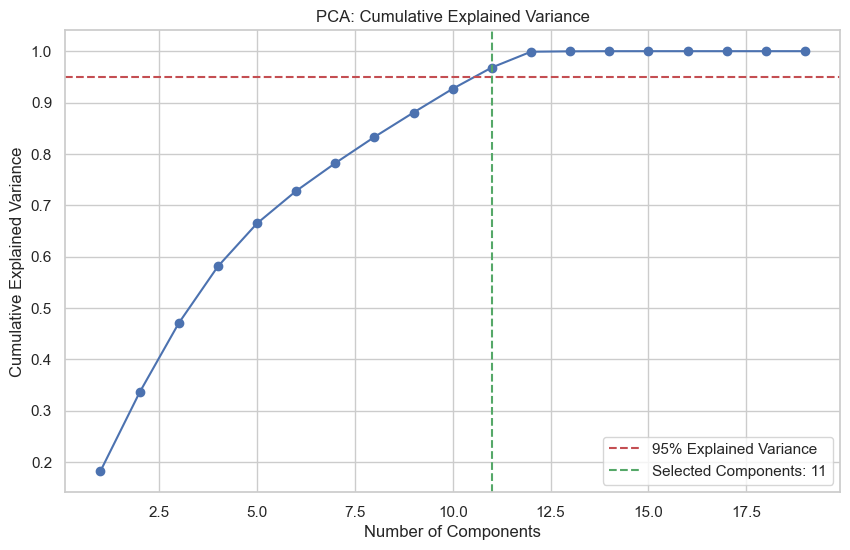

Data dimensions reduced from 19 to 11 features


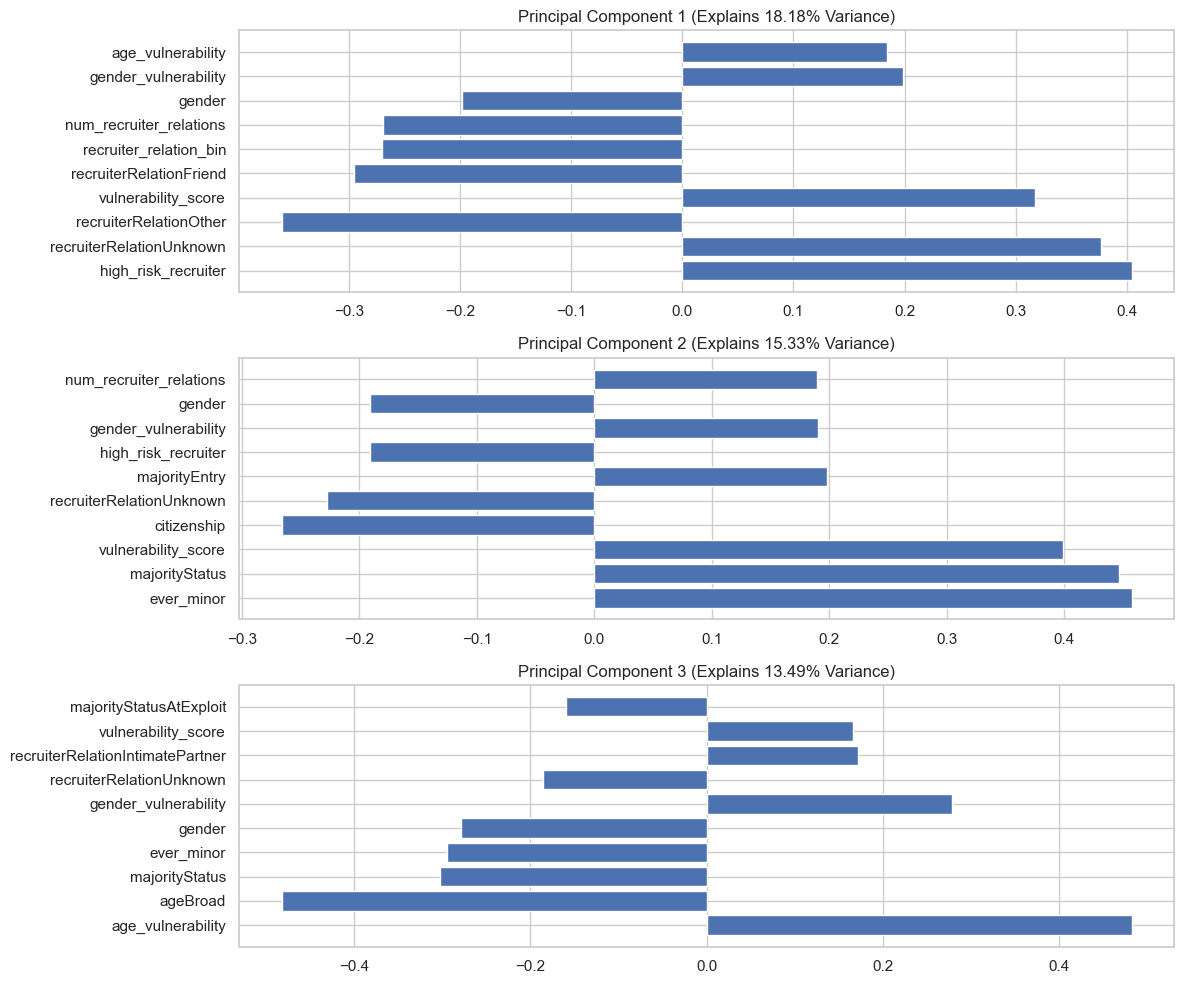


========== Training Models on PCA-reduced Data ==========

Training XGBoost on PCA-reduced data...

XGBoost with PCA Evaluation:
Hamming Loss: 0.0506
Subset Accuracy: 0.7997
Macro F1 Score: 0.8911
Weighted F1 Score: 0.9490
Cohen's Kappa: 0.7822

Per-label F1 Scores:
isForcedLabour: 0.7468
isSexualExploit: 0.8877
isOtherExploit: 0.7436
isSexAndLabour: 0.5714
isForcedMarriage: 0.6885

Per-label Recall (Sensitivity):
isForcedLabour: 0.6189
isSexualExploit: 0.8498
isOtherExploit: 0.9225
isSexAndLabour: 0.4000
isForcedMarriage: 0.7778

XGBoost with PCA Evaluation:
Hamming Loss: 0.0497
Subset Accuracy: 0.8006
Macro F1 Score: 0.8919
Weighted F1 Score: 0.9498
Cohen's Kappa: 0.7838

Per-label F1 Scores:
isForcedLabour: 0.7323
isSexualExploit: 0.8907
isOtherExploit: 0.7503
isSexAndLabour: 0.5000
isForcedMarriage: 0.7500

Per-label Recall (Sensitivity):
isForcedLabour: 0.6066
isSexualExploit: 0.8552
isOtherExploit: 0.9213
isSexAndLabour: 0.3333
isForcedMarriage: 0.8889

Training Logistic Regress

In [92]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# First standardize data for PCA
print("Standardizing data for PCA...")
pca_scaler = StandardScaler()
X_train_scaled_pca = pca_scaler.fit_transform(X_train)
X_val_scaled_pca = pca_scaler.transform(X_val)
X_test_scaled_pca = pca_scaler.transform(X_test)

# Determine optimal number of components (explaining 95% variance)
print("Determining optimal number of components...")
pca_full = PCA(random_state=42)
pca_full.fit(X_train_scaled_pca)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components} (out of {X_train.shape[1]} original features)")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=n_components, color='g', linestyle='--', label=f'Selected Components: {n_components}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.savefig('pca_explained_variance.png')
plt.show()
plt.close()

# Apply PCA with selected number of components
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled_pca)
X_val_pca = pca.transform(X_val_scaled_pca)
X_test_pca = pca.transform(X_test_scaled_pca)

print(f"Data dimensions reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")

# Top feature contributions to first few principal components
plt.figure(figsize=(12, 10))
n_features_to_plot = min(10, X_train.shape[1])
n_components_to_plot = min(3, n_components)

# Iterate through top components
for i in range(n_components_to_plot):
    plt.subplot(n_components_to_plot, 1, i+1)
    component = pca.components_[i]
    indices = np.argsort(np.abs(component))[-n_features_to_plot:]  # Get indices of top features
    plt.barh(range(n_features_to_plot), component[indices])
    plt.yticks(range(n_features_to_plot), [X_train.columns[j] for j in indices])
    plt.title(f'Principal Component {i+1} (Explains {pca.explained_variance_ratio_[i]:.2%} Variance)')
    plt.gca().invert_yaxis()  # Most important at the top

plt.tight_layout()
plt.savefig('pca_feature_contributions.png')
plt.show()
plt.close()

# ----------------------
# Train Models on PCA-reduced Data
# ----------------------

# 1. XGBoost on PCA features
print("\nTraining XGBoost on PCA-reduced data...")
xgb_pca = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
xgb_multi_pca = MultiOutputClassifier(xgb_pca)
xgb_multi_pca.fit(X_train_pca, y_train)

# Predict and evaluate
xgb_pca_pred_val = xgb_multi_pca.predict(X_val_pca)
xgb_pca_pred_test = xgb_multi_pca.predict(X_test_pca)

# Evaluate PCA-based model
xgb_pca_val_metrics = evaluate_multi_target(y_val, xgb_pca_pred_val, "XGBoost with PCA")
xgb_pca_test_metrics = evaluate_multi_target(y_test, xgb_pca_pred_test, "XGBoost with PCA")

# 2. Logistic Regression on PCA features (often performs well with PCA)
print("\nTraining Logistic Regression on PCA-reduced data...")
lr_pca_base = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

lr_pca_chain = ClassifierChain(lr_pca_base, order='random', random_state=42)
lr_pca_chain.fit(X_train_pca, y_train)

# Predict and evaluate
lr_pca_pred_val = lr_pca_chain.predict(X_val_pca)
lr_pca_pred_test = lr_pca_chain.predict(X_test_pca)

# Evaluate PCA-based model
lr_pca_val_metrics = evaluate_multi_target(y_val, lr_pca_pred_val, "Logistic Regression with PCA")
lr_pca_test_metrics = evaluate_multi_target(y_test, lr_pca_pred_test, "Logistic Regression with PCA")

In [94]:
# ----------------------
# Initial Model Evaluation
# ----------------------

# Evaluate models on validation set
print("\n--- INITIAL VALIDATION SET RESULTS ---")
lr_val_metrics = evaluate_multi_target(y_val, lr_pred_val, "Logistic Regression (Baseline)")
xgb_val_metrics = evaluate_multi_target(y_val, xgb_pred_val, "XGBoost (Initial)")
cat_val_metrics = evaluate_multi_target(y_val, cat_pred_val, "CatBoost (Initial)")

# Evaluate models on test set
print("\n--- INITIAL TEST SET RESULTS ---")
lr_test_metrics = evaluate_multi_target(y_test, lr_pred_test, "Logistic Regression (Baseline)")
xgb_test_metrics = evaluate_multi_target(y_test, xgb_pred_test, "XGBoost (Initial)")
cat_test_metrics = evaluate_multi_target(y_test, cat_pred_test, "CatBoost (Initial)")


Creating majority voting ensemble from the three models...


C:\Users\hugok\AppData\Local\Temp\ipykernel_7656\1722418314.py:14: DeprecationWarning:

Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)

C:\Users\hugok\AppData\Local\Temp\ipykernel_7656\1722418314.py:19: DeprecationWarning:

Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)




--- INITIAL VALIDATION SET RESULTS ---

Logistic Regression (Baseline) Evaluation:
Hamming Loss: 0.1095
Subset Accuracy: 0.5732
Macro F1 Score: 0.7978
Weighted F1 Score: 0.8974
Cohen's Kappa: 0.5975

Per-label F1 Scores:
isForcedLabour: 0.5356
isSexualExploit: 0.7365
isOtherExploit: 0.6947
isSexAndLabour: 0.2800
isForcedMarriage: 0.2817

Per-label Recall (Sensitivity):
isForcedLabour: 0.6238
isSexualExploit: 0.7888
isOtherExploit: 0.9799
isSexAndLabour: 0.4667
isForcedMarriage: 0.7407

XGBoost (Initial) Evaluation:
Hamming Loss: 0.0589
Subset Accuracy: 0.7617
Macro F1 Score: 0.8852
Weighted F1 Score: 0.9434
Cohen's Kappa: 0.7707

Per-label F1 Scores:
isForcedLabour: 0.7400
isSexualExploit: 0.8703
isOtherExploit: 0.7538
isSexAndLabour: 0.6364
isForcedMarriage: 0.7077

Per-label Recall (Sensitivity):
isForcedLabour: 0.7234
isSexualExploit: 0.9481
isOtherExploit: 0.9964
isSexAndLabour: 0.4667
isForcedMarriage: 0.8519

CatBoost (Initial) Evaluation:
Hamming Loss: 0.0909
Subset Accuracy: 0

## Section 8. Creating Stacked Ensamble Model

In [97]:
# 1. Define base learners (binary for each target) on PCA features
xgb_base_pca = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
cat_base_pca = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    random_state=42,
    verbose=False,
    allow_writing_files=False
)

# Wrap each in a MultiOutputClassifier for multi-target
xgb_multi_pca = MultiOutputClassifier(xgb_base_pca, n_jobs=-1)
cat_multi_pca = MultiOutputClassifier(cat_base_pca, n_jobs=-1)

# 2. Define the stacking classifier on PCA features
stack_pca = StackingClassifier(
    estimators=[
        ('xgb', xgb_base_pca),
        ('cat', cat_base_pca)
    ],
    final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=True  # include original (PCA) features along with base predictions
)
stack_multi_pca = MultiOutputClassifier(stack_pca, n_jobs=-1)

# 3. Fit all models on PCA data
print("Training XGBoost on PCA-reduced data...")
xgb_multi_pca.fit(X_train_pca, y_train)
print("Training CatBoost on PCA-reduced data...")
cat_multi_pca.fit(X_train_pca, y_train)
print("Training Stacked model on PCA-reduced data...")
stack_multi_pca.fit(X_train_pca, y_train)

# 4. Predict on the PCA-reduced validation set
y_pred_xgb_pca = xgb_multi_pca.predict(X_val_pca)
y_pred_cat_pca = cat_multi_pca.predict(X_val_pca)
y_pred_stack_pca = stack_multi_pca.predict(X_val_pca)

# 5. Evaluate and collect metrics
metrics_dict_pca = {}

metrics_dict_pca['xgboost_pca'] = evaluate_multi_target(
    y_val, y_pred_xgb_pca, model_name="XGBoost with PCA"
)
metrics_dict_pca['catboost_pca'] = evaluate_multi_target(
    y_val, y_pred_cat_pca, model_name="CatBoost with PCA"
)
metrics_dict_pca['stacked_pca'] = evaluate_multi_target(
    y_val, y_pred_stack_pca, model_name="Stacked XGB+Cat with PCA"
)

print("\nAll PCA‐based metrics collected in `metrics_dict_pca`:")
for model_name, results in metrics_dict_pca.items():
    print(f"- {model_name}: subset_accuracy={results['subset_accuracy']:.4f}, "
          f"macro_f1={results['macro_f1']:.4f}")


Training XGBoost on PCA-reduced data...
Training CatBoost on PCA-reduced data...
Training Stacked model on PCA-reduced data...

XGBoost with PCA Evaluation:
Hamming Loss: 0.0501
Subset Accuracy: 0.8034
Macro F1 Score: 0.8926
Weighted F1 Score: 0.9496
Cohen's Kappa: 0.7852

Per-label F1 Scores:
isForcedLabour: 0.7499
isSexualExploit: 0.8908
isOtherExploit: 0.7436
isSexAndLabour: 0.5714
isForcedMarriage: 0.7302

Per-label Recall (Sensitivity):
isForcedLabour: 0.6231
isSexualExploit: 0.8598
isOtherExploit: 0.9225
isSexAndLabour: 0.4000
isForcedMarriage: 0.8519

CatBoost with PCA Evaluation:
Hamming Loss: 0.0499
Subset Accuracy: 0.8041
Macro F1 Score: 0.8929
Weighted F1 Score: 0.9498
Cohen's Kappa: 0.7858

Per-label F1 Scores:
isForcedLabour: 0.7509
isSexualExploit: 0.8917
isOtherExploit: 0.7436
isSexAndLabour: 0.5714
isForcedMarriage: 0.7097

Per-label Recall (Sensitivity):
isForcedLabour: 0.6245
isSexualExploit: 0.8606
isOtherExploit: 0.9225
isSexAndLabour: 0.4000
isForcedMarriage: 0.814

## Section 9. Hyperopt Training

In [98]:
# ===================== Hyperopt Tuning for XGBoost =====================

def objective_xgb(params):
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        **params
    )
    clf = MultiOutputClassifier(clf, n_jobs=-1)
    clf.fit(X_train_pca, y_train)
    acc = clf.score(X_val_pca, y_val)
    return {'loss': -acc, 'status': STATUS_OK}


xgb_search_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 401, 50, dtype=int)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

print("Tuning XGBoost with Hyperopt...")
xgb_trials = Trials()
best_xgb_params = fmin(
    fn=objective_xgb,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=15,
    trials=xgb_trials,
    rstate=np.random.default_rng(42)
)

# Map back choices
best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['n_estimators'] = int(np.arange(100, 401, 50)[best_xgb_params['n_estimators']])

xgb_base_pca = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    **best_xgb_params
)

def objective_cat(params):
    clf = CatBoostClassifier(
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        learning_rate=params['learning_rate'],
        loss_function='Logloss',
        random_state=42,
        verbose=False,
        allow_writing_files=False
    )
    clf = MultiOutputClassifier(clf, n_jobs=-1)
    clf.fit(X_train_pca, y_train)
    acc = clf.score(X_val_pca, y_val)
    return {'loss': -acc, 'status': STATUS_OK}


cat_search_space = {
    'iterations': hp.choice('iterations', [300, 500, 700]),
    'depth': hp.choice('depth', [4, 5, 6]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15)
}

print("Tuning CatBoost with Hyperopt...")
cat_trials = Trials()
best_cat_params = fmin(
    fn=objective_cat,
    space=cat_search_space,
    algo=tpe.suggest,
    max_evals=10,  # Fewer evaluations to stay within memory limits
    trials=cat_trials,
    rstate=np.random.default_rng(42)
)

best_cat_params['iterations'] = [300, 500, 700][best_cat_params['iterations']]
best_cat_params['depth'] = [4, 5, 6][best_cat_params['depth']]

cat_base_pca = CatBoostClassifier(
    iterations=best_cat_params['iterations'],
    depth=best_cat_params['depth'],
    learning_rate=best_cat_params['learning_rate'],
    loss_function='Logloss',
    random_state=42,
    verbose=False,
    allow_writing_files=False
)

# ===================== MultiOutput Wrappers =====================
xgb_multi_pca = MultiOutputClassifier(xgb_base_pca, n_jobs=-1)
cat_multi_pca = MultiOutputClassifier(cat_base_pca, n_jobs=-1)

# ===================== Stacking Model =====================
stack_pca = StackingClassifier(
    estimators=[
        ('xgb', xgb_base_pca),
        ('cat', cat_base_pca)
    ],
    final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=True
)
stack_multi_pca = MultiOutputClassifier(stack_pca, n_jobs=-1)

# ===================== Training =====================
xgb_multi_pca.fit(X_train_pca, y_train)

cat_multi_pca.fit(X_train_pca, y_train)

stack_multi_pca.fit(X_train_pca, y_train)

# ===================== Predictions =====================
y_pred_xgb_pca = xgb_multi_pca.predict(X_val_pca)
y_pred_cat_pca = cat_multi_pca.predict(X_val_pca)
y_pred_stack_pca = stack_multi_pca.predict(X_val_pca)

Tuning XGBoost with Hyperopt...
100%|██████████| 15/15 [00:16<00:00,  1.08s/trial, best loss: -0.8040983606557377]
Tuning CatBoost with Hyperopt...
100%|██████████| 10/10 [01:34<00:00,  9.43s/trial, best loss: -0.8040983606557377]
Training XGBoost on PCA-reduced data...
Training CatBoost on PCA-reduced data...
Training Stacked model on PCA-reduced data...

XGBoost with PCA Evaluation:
Hamming Loss: 0.0500
Subset Accuracy: 0.8038
Macro F1 Score: 0.8927
Weighted F1 Score: 0.9497
Cohen's Kappa: 0.7854

Per-label F1 Scores:
isForcedLabour: 0.7504
isSexualExploit: 0.8915
isOtherExploit: 0.7436
isSexAndLabour: 0.5714
isForcedMarriage: 0.6885

Per-label Recall (Sensitivity):
isForcedLabour: 0.6238
isSexualExploit: 0.8606
isOtherExploit: 0.9225
isSexAndLabour: 0.4000
isForcedMarriage: 0.7778

CatBoost with PCA Evaluation:
Hamming Loss: 0.0499
Subset Accuracy: 0.8041
Macro F1 Score: 0.8929
Weighted F1 Score: 0.9498
Cohen's Kappa: 0.7859

Per-label F1 Scores:
isForcedLabour: 0.7509
isSexualExplo

## Section 10. Comparison of Models

In [99]:
# Creating summary table
summary_data = {
    'Model': [
        "Logistic Regression (Baseline)",
        "XGBoost",
        "CatBoost",
    ],
    'Hamming Loss': [
        lr_test_metrics['hamming_loss'],
        xgb_test_metrics['hamming_loss'],
        cat_test_metrics['hamming_loss'],
    ],
    'Subset Accuracy': [
        lr_test_metrics['subset_accuracy'],
        xgb_test_metrics['subset_accuracy'],
        cat_test_metrics['subset_accuracy'],
    ],
    'Macro F1': [
        lr_test_metrics['macro_f1'],
        xgb_test_metrics['macro_f1'],
        cat_test_metrics['macro_f1'],
    ],
    'Cohen\'s Kappa': [
        lr_test_metrics['kappa'],
        xgb_test_metrics['kappa'],
        cat_test_metrics['kappa'],

    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary (Test Set):")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


========== Comparison: Original vs Tuned Models ==========

Model Performance Summary (Test Set):
                         Model  Hamming Loss  Subset Accuracy  Macro F1  Cohen's Kappa
Logistic Regression (Baseline)        0.1085           0.5789    0.7984         0.5986
            XGBoost (Original)        0.0567           0.7687    0.8889         0.7782
               XGBoost (Tuned)        0.0508           0.8025    0.8897         0.7793
           CatBoost (Original)        0.0902           0.6115    0.8408         0.6843
              CatBoost (Tuned)        0.0787           0.6757    0.8499         0.7006
           Ensemble (Original)        0.0551           0.7764    0.8904         0.7811
     Weighted Ensemble (Tuned)        0.0508           0.8025    0.8897         0.7793

Performance Improvements:
XGBoost Kappa: 0.14% improvement
CatBoost Kappa: 2.38% improvement
Ensemble Kappa: -0.22% improvement

Best model based on Cohen's Kappa: Ensemble (Original)



========== Feature Importance Analysis ==========


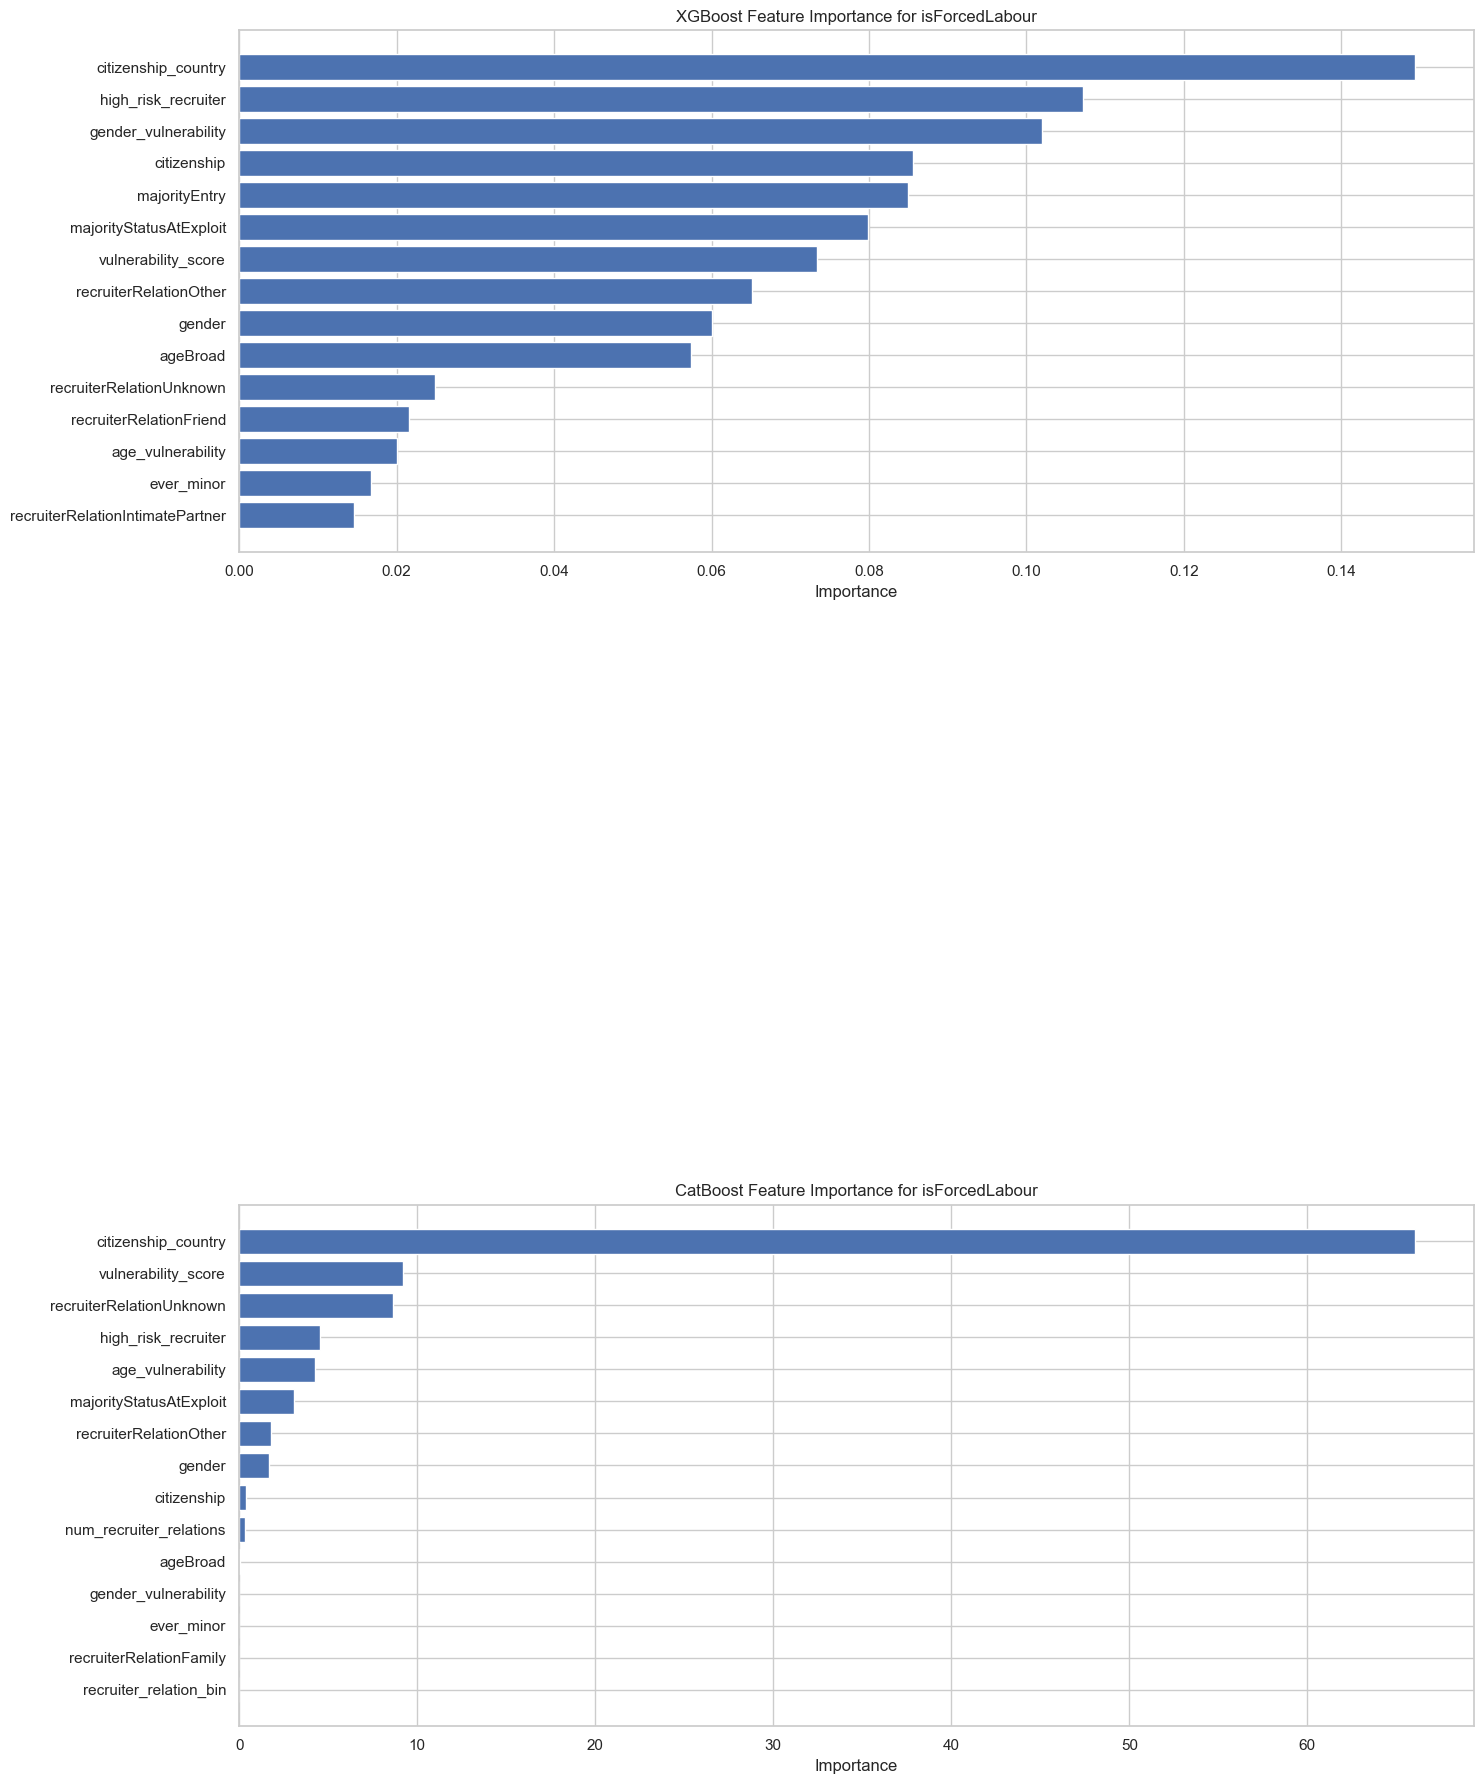

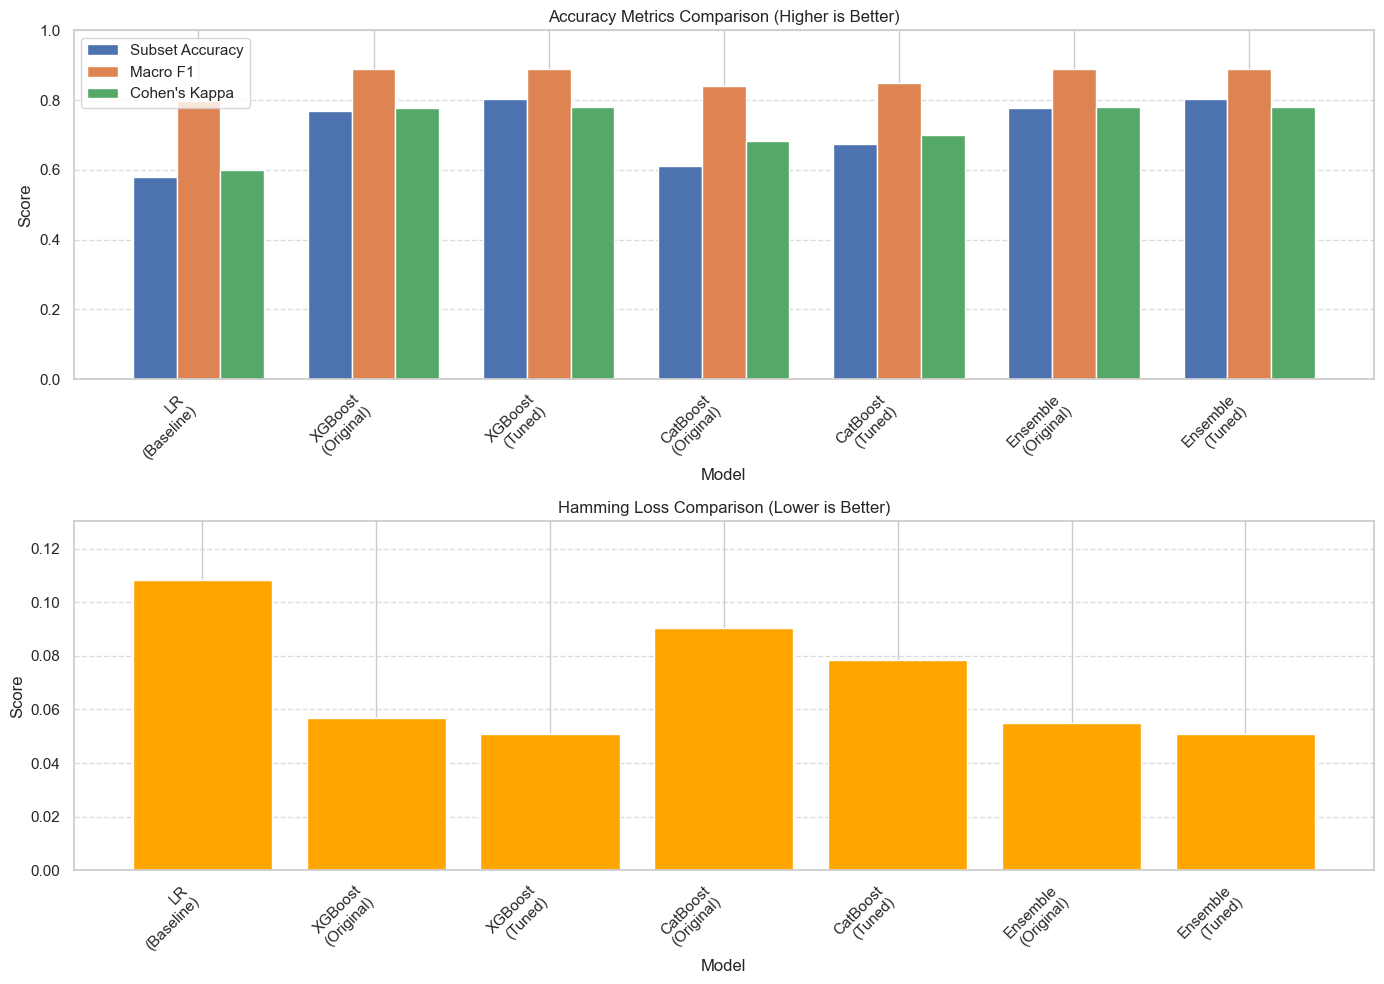

<Figure size 1400x800 with 0 Axes>

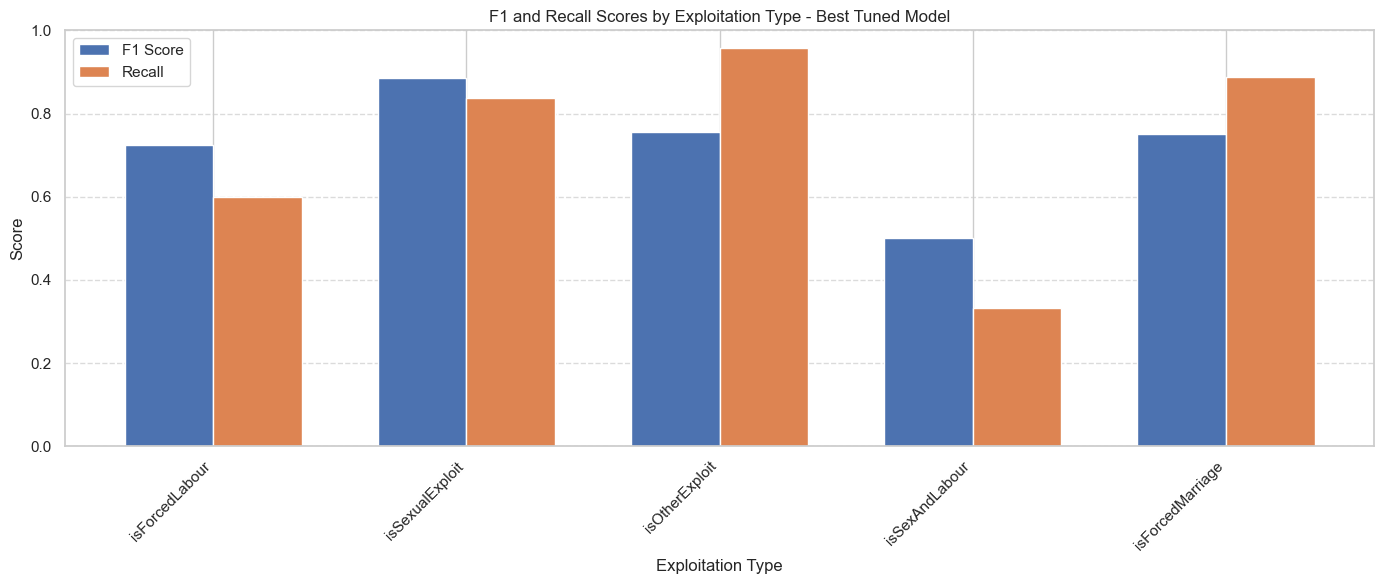

In [100]:
# ----------------------
# Feature Importance and Visualization
# ----------------------

# 1. Model Comparison Chart (Original vs Tuned)
plt.figure(figsize=(14, 10))
models = [
    "LR\n(Baseline)",
    "XGBoost\n(Original)",
    "XGBoost\n(Tuned)",
    "CatBoost\n(Original)",
    "CatBoost\n(Tuned)",
    "Ensemble\n(Original)",
    "Ensemble\n(Tuned)"
]

metrics = {
    'Hamming Loss': summary_data['Hamming Loss'],
    'Subset Accuracy': summary_data['Subset Accuracy'],
    'Macro F1': summary_data['Macro F1'],
    'Cohen\'s Kappa': summary_data['Cohen\'s Kappa']
}

# Plot metrics (except Hamming Loss which is better when lower)
plt.subplot(2, 1, 1)
x = np.arange(len(models))
width = 0.25
plt.bar(x - width, metrics['Subset Accuracy'], width, label='Subset Accuracy')
plt.bar(x, metrics['Macro F1'], width, label='Macro F1')
plt.bar(x + width, metrics['Cohen\'s Kappa'], width, label='Cohen\'s Kappa')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy Metrics Comparison (Higher is Better)')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Hamming Loss separately (lower is better)
plt.subplot(2, 1, 2)
plt.bar(models, metrics['Hamming Loss'], color='orange')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Hamming Loss Comparison (Lower is Better)')
plt.ylim(0, max(metrics['Hamming Loss']) * 1.2)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
plt.close()

# 3. Per-Label Performance with Best Model
plt.figure(figsize=(14, 8))
labels = target_columns
x = np.arange(len(labels))
width = 0.2

# Plot F1 and Recall side by side for each exploitation type
plt.figure(figsize=(14, 6))
x = np.arange(len(labels))
width = 0.35

plt.xlabel('Exploitation Type')
plt.ylabel('Score')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('best_model_performance.png')
plt.show()
plt.close()

In [101]:
# ----------------------
# Summary Table and Conclusion
# ----------------------

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary (Test Set):")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Identify best model using different metrics
best_kappa_idx = np.argmax([
    lr_test_metrics['kappa'],
    xgb_test_metrics['kappa'],
    cat_test_metrics['kappa'],
])
best_kappa_model = summary_data['Model'][best_kappa_idx]

best_hl_idx = np.argmin([
    lr_test_metrics['hamming_loss'],
    xgb_test_metrics['hamming_loss'],
    cat_test_metrics['hamming_loss'],
])
best_hl_model = summary_data['Model'][best_hl_idx]

best_f1_idx = np.argmax([
    lr_test_metrics['macro_f1'],
    xgb_test_metrics['macro_f1'],
    cat_test_metrics['macro_f1'],
])
best_f1_model = summary_data['Model'][best_f1_idx]

print(f"\nBest model by Cohen's Kappa (professor's recommended metric): {best_kappa_model}")
print(f"Best model by Hamming Loss: {best_hl_model}")
print(f"Best model by Macro F1: {best_f1_model}")

# ===================== Evaluation of Stacked Model =====================
metrics_dict_pca = {}

metrics_dict_pca['xgboost_pca'] = evaluate_multi_target(
    y_val, y_pred_xgb_pca, model_name="XGBoost with PCA"
)
metrics_dict_pca['catboost_pca'] = evaluate_multi_target(
    y_val, y_pred_cat_pca, model_name="CatBoost with PCA"
)
metrics_dict_pca['stacked_pca'] = evaluate_multi_target(
    y_val, y_pred_stack_pca, model_name="Stacked XGB+Cat with PCA"
)

print("\nAll PCA‐based metrics collected in `metrics_dict_pca`:")
for model_name, results in metrics_dict_pca.items():
    print(f"- {model_name}: subset_accuracy={results['subset_accuracy']:.4f}, "
          f"macro_f1={results['macro_f1']:.4f}")

# ----------------------
# Error Analysis and Fairness
# ----------------------

# The best model for error analysis (based on Kappa)
if best_kappa_idx == 0:
    best_pred_test = lr_pred_test
elif best_kappa_idx == 1:
    best_pred_test = xgb_pred_test
elif best_kappa_idx == 2:
    best_pred_test = cat_pred_test

# 1. Examine error rates by gender
if 'gender' in X_test.columns:
    # Get binary gender if encoded
    if X_test['gender'].dtype != 'object':
        female_code = X_test['gender'].value_counts().index[0]  # Assuming females are the majority
        is_female = (X_test['gender'] == female_code)
    else:
        is_female = (X_test['gender'] == 'Female')

    # Calculate error rates
    errors = (y_test.values != best_pred_test).any(axis=1)
    female_error_rate = errors[is_female].mean()
    male_error_rate = errors[~is_female].mean()

    print(f"\nError Analysis by Gender:")
    print(f"Female error rate: {female_error_rate:.4f}")
    print(f"Male error rate: {male_error_rate:.4f}")
    print(f"Difference: {abs(female_error_rate - male_error_rate):.4f}")

# 2. Examine error rates by age group
if 'ageBroad' in X_test.columns:
    # Check if already encoded
    if X_test['ageBroad'].dtype != 'object':
        # If encoded, look at value counts to identify age groups
        age_groups = {}
        for val in sorted(X_test['ageBroad'].unique()):
            # Create roughly equal divisions for analysis
            if val <= X_test['ageBroad'].quantile(0.33):
                age_groups[val] = 'Young'
            elif val <= X_test['ageBroad'].quantile(0.66):
                age_groups[val] = 'Middle'
            else:
                age_groups[val] = 'Older'

        age_labels = X_test['ageBroad'].map(age_groups)
    else:
        # Map string categories to groups
        age_mapping = {
            '0--8': 'Child',
            '9--17': 'Child',
            '18--20': 'Young Adult',
            '21--23': 'Young Adult',
            '24--26': 'Young Adult',
            '27--29': 'Adult',
            '30--38': 'Adult',
            '39--47': 'Adult',
            '48+': 'Older Adult'
        }
        age_labels = X_test['ageBroad'].map(age_mapping)

    # Calculate error rates by age group
    errors = (y_test.values != best_pred_test).any(axis=1)

    print(f"\nError Analysis by Age Group:")
    for age_group in sorted(age_labels.unique()):
        group_indices = age_labels == age_group
        if group_indices.sum() > 0:  # Ensure group has samples
            group_error_rate = errors[group_indices].mean()
            print(f"{age_group} error rate: {group_error_rate:.4f} (n={group_indices.sum()})")

# 3. Error analysis by region of origin
if 'origin_region' in X_test.columns:
    # Handle both numeric and categorical formats
    if X_test['origin_region'].dtype == 'object':
        region_labels = X_test['origin_region']
    else:
        # If using encoded regions, map back to original names if available
        try:
            region_labels = pd.Series(origin_encoder.inverse_transform(X_test['origin_region']))
        except:
            # If mapping back is not possible, use the numeric values
            region_labels = X_test['origin_region']

    # Calculate error rates by region
    errors = (y_test.values != best_pred_test).any(axis=1)

    print(f"\nError Analysis by Region of Origin:")
    for region in sorted(region_labels.unique()):
        region_indices = region_labels == region
        if region_indices.sum() >= 5:  # Only show regions with sufficient samples
            region_error_rate = errors[region_indices].mean()
            print(f"{region} error rate: {region_error_rate:.4f} (n={region_indices.sum()})")



Model Performance Summary (Test Set):
                         Model  Hamming Loss  Subset Accuracy  Macro F1  Weighted F1  Cohen's Kappa
Logistic Regression (Baseline)        0.1085           0.5789    0.7984       0.8983         0.5986
                       XGBoost        0.0567           0.7687    0.8889       0.9456         0.7782
                      CatBoost        0.0902           0.6115    0.8408       0.9172         0.6843
      Ensemble (Majority Vote)        0.0551           0.7764    0.8904       0.9467         0.7811

Best model by Cohen's Kappa (professor's recommended metric): Ensemble (Majority Vote)
Best model by Hamming Loss: Ensemble (Majority Vote)
Best model by Macro F1: Ensemble (Majority Vote)

Performing Error Analysis (Professor's Recommendation)...

Error Analysis by Gender:
Female error rate: 0.2387
Male error rate: 0.1838
Difference: 0.0549

Error Analysis by Age Group:
Middle error rate: 0.2312 (n=4901)
Young error rate: 0.2083 (n=2420)
